In [1]:
using PyPlot, Random, SpecialFunctions, ProgressMeter

### Experiments for "Mean-Field Lagevin Dynamics: Exponential convergence and annealing"

We consider interacting particles on the 2d torus $(\mathbb{R}/\mathbb{Z})^d$, with a positive semi-definite interaction kernel. 

Definition of the interaction kernel and its derivatives:

In [2]:
#modified Dirichlet kernel
dc = 1.0 # decay coefficient of the frequency components
dirichlet(x,n)  = (1 + 2*sum(cos.(k*x[1])/(1+k^dc) for k=1:n))*(1 + 2*sum(cos.(k*x[2])/(1+k^dc) for k=1:n))
dirichlet(x,y,n)  = (1 + 2*sum(cos.(k*x)/(1+k^dc) for k=1:n))*(1 + 2*sum(cos.(k*y)/(1+k^dc) for k=1:n))
# the partial derivatives
d1_dirichlet(x,n)  = 2*sum(-k*sin.(k*x[1])/(1+k^dc) for k=1:n)*(1 + 2*sum(cos.(k*x[2])/(1+k^dc) for k=1:n))
d2_dirichlet(x,n)  = 2*sum(-k*sin.(k*x[2])/(1+k^dc) for k=1:n)*(1 + 2*sum(cos.(k*x[1])/(1+k^dc) for k=1:n))


d2_dirichlet (generic function with 1 method)

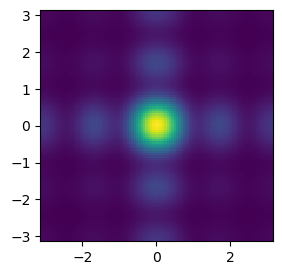

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [3]:
figure(figsize=[3,3])
xs = range(-π,π,length=100)
pcolor(xs,xs,dirichlet.(xs,xs',4));

The objective function involves the entropy, which we estimate with a nearest-neighbor estimator.

In [4]:
"k-NN entropy estimator for the point cloud X of m points in the d-dimension torus"
function kNN_entropy_est(X,k=1)
    d,m = size(X)
    dists = [ sqrt(sum(min.(mod.(X[:,i]-X[:,j],2π),mod.(-X[:,i]+X[:,j],2π)).^2)) for i=1:m, j=1:m ] #computes twice as much as needed
    kdist = [partialsort(dists[:,i], k+1) for i=1:m]
    return - digamma(m) + digamma(k) - (d/2)*log(π) + log(gamma(1+d/2)) - (d/m)*sum(log.(kdist))
end

kNN_entropy_est

Main algorithm that computes the evolution of the particles

In [10]:
function PGD(X_init, X_target, tau, niter; annealed=true)
stepsize = 0.08
n = 5 #nb of freq component in the Dirichlet kernel
grad=zeros(d,m)
G = zeros(niter-1)
H = zeros(niter-1)
F = zeros(niter-1)
X = zeros(d, m , niter)
X[:,:,1] = X_init
tau_t = tau
for t = 1:niter-1
    G[t] = ( sum(dirichlet(X[:,i,t] - X[:,j,t],n) for i=1:m, j=1:m)/m^2 
            - 2*sum(dirichlet(X[:,i,t] - X_target[:,j],n) for i=1:m, j=1:m_target)/(m*m_target)
            + sum(dirichlet(X_target[:,i] - X_target[:,j],n) for i=1:m_target, j=1:m_target)/m_target^2)
    
    H[t] = kNN_entropy_est(X[:,:,t],1)
    if annealed
        tau_t = tau*(t+1)^(-1)
    else
        tau_t = tau
    end
    F[t] = G[t] + tau_t * H[t]
    for i=1:m
        grad[1,i] = (sum( d1_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                        - sum( d1_dirichlet(X[:,i,t] - X_target[:,j], n ) for j=1:m_target)/m_target )
        grad[2,i] = (sum( d2_dirichlet(X[:,i,t] - X[:,j,t], n) for j=1:m)/m 
                        - sum( d2_dirichlet(X[:,i,t] - X_target[:,j], n ) for j=1:m_target)/m_target )
    end
    if t>niter*0.8
        X[:,:,t+1] = X[:,:,t] .- stepsize * grad
    else 
        X[:,:,t+1] = X[:,:,t] .- stepsize * grad .+ sqrt(2*stepsize*tau_t) * randn(d,m)
    end
end
    return X, G, H, F
end

PGD (generic function with 1 method)

# Illustration

In [11]:
Random.seed!(1)
niter=1000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
d=2
X_target = 2π*rand(d, m_target) # ground truth
X_init = 2π*rand(d, m); # random init
@time X, G, H, F = PGD(X_init, X_target, 0.1, niter, annealed=false);

 17.219818 seconds (535.68 M allocations: 11.696 GiB, 5.52% gc time, 3.37% compilation time)


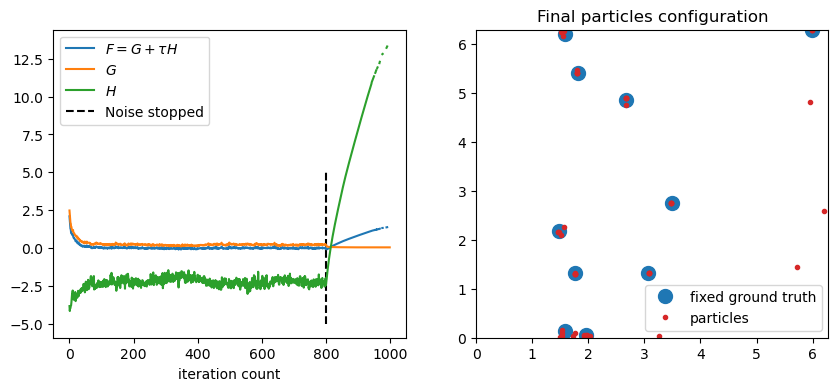

PyObject <matplotlib.legend.Legend object at 0x7ff2106b85b0>

In [15]:
figure(figsize=[10,4])
subplot(121)
plot(F,label=L"F=G+\tau H")
plot(G,label=L"G")
plot(H,label=L"H")
vlines(800,-5,5,"k",ls="--",label="Noise stopped")
legend()
xlabel("iteration count")
subplot(122)
axis([0,2π,0,2π])
plot(X_target[1,:], X_target[2,:],"o",ms=10,color="C0",label="fixed ground truth")
plot(mod.(X[1,:,end],2π),mod.(X[2,:,end],2π),"oC3",ms=3,label="particles")
title("Final particles configuration")
legend()

# Convergence speed without annealing (long)

In [325]:
Random.seed!(1)
niter=1000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
nrep = 10 #nb of repetitions
taus = [0.03,0.1,0.3]
Fs = zeros(nrep,length(taus),niter-1)
for i=1:length(taus)
@showprogress "Computing..."   for j=1:nrep
        X_target = 2π*rand(d, m_target)
        X_init = 2π*rand(d, m);
        X, G, H, F = PGD(X_init, X_target, taus[i], niter, annealed=false);
        Fs[j,i,:] = F
    end
end

Computing...100%|███████████████████████████████████████| Time: 0:02:29
Computing...100%|███████████████████████████████████████| Time: 0:02:32
Computing...100%|███████████████████████████████████████| Time: 0:02:32


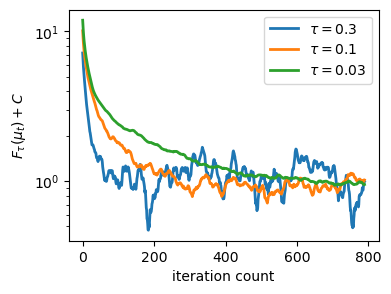

In [345]:
figure(figsize=[4,3])
A1 = sum(Fs[:,1,1:800].- minimum(Fs[:,1,:],dims=2),dims=1)'/10
A2 = sum(Fs[:,2,1:800].- minimum(Fs[:,2,:],dims=2),dims=1)'/10 
A3 = sum(Fs[:,3,1:800].- minimum(Fs[:,3,:],dims=2),dims=1)'/10 

# we add a constant so that the convergence is easier to compare (the final value cannot be directly compared anyways)
semilogy([sum(A3[i:i+10]) .- 5.4 for i=1:790] ,"C0",lw=2,label=L"\tau=0.3")
semilogy([sum(A2[i:i+10])  .- 1.1 for i=1:790]  ,"C1",lw=2,label=L"\tau=0.1")
semilogy( [sum(A1[i:i+10]) .+ 0.4  for i=1:790] ,"C2",lw=2,label=L"\tau=0.03")
legend()


xlabel("iteration count")
ylabel(L"F_\tau(\mu_t)+C")
savefig("convergence-final.png",bbox_inches="tight")

# Convergence speed with annealing & comparison PGD vs NPGD (long)


In [318]:
# takes 5 minutes
Random.seed!(1)
niter=1000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
G1s = zeros(niter-1,10)
G2s = zeros(niter-1,10)
@showprogress "Computing..."  for k=1:10
X_target = 2π*rand(d, m_target)
X_init = 2π*rand(d, m);
X1, G1 = PGD(X_init, X_target, 0.0, niter,annealed=true);
X2, G2 = PGD(X_init, X_target, 20.0, niter,annealed=true);
    G1s[:,k]=G1
    G2s[:,k]=G2
end

Computing...100%|███████████████████████████████████████| Time: 0:04:56


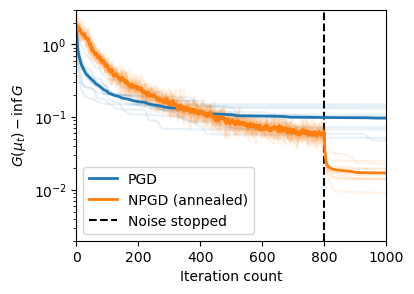

In [324]:
figure(figsize=[4,3])
for k=1:10
semilogy(G1s[:,k],alpha=0.1,"C0")
semilogy(G2s[:,k],alpha=0.1,"C1")
end
semilogy(sum(G1s,dims=2)/10,"C0",lw=2,label="PGD")
semilogy(sum(G2s,dims=2)/10,"C1",lw=2,label="NPGD (annealed)")
vlines(800,0.002,10,"k",ls="--",label="Noise stopped")
legend(loc=3)
xlabel("Iteration count")
ylabel(L"G(\mu_t)-\inf G")
axis([0,1000,0.002,3])
savefig("compare-NPGD.png",bbox_inches="tight")

# Video animation

In [37]:
# takes 30 sec
Random.seed!(2)
niter=2000
m_target = 10 # nb of ground truth particles
m = 50 # nb of particles
X_target = 2π*rand(d, m_target)
X_init = 2π*rand(d, m);
@time X1, G1 = PGD(X_init, X_target, 0.0, niter,annealed=false); #no noise
@time X2, G2 = PGD(X_init, X_target, 20, niter,annealed=true); # noise # choose annealed (tau=20)or not (tau=0.1)

 34.600392 seconds (1.07 G allocations: 23.125 GiB, 6.59% gc time, 0.23% compilation time)


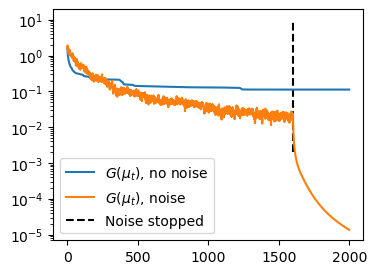

In [38]:
figure(figsize=[4,3])
semilogy(G1,label=L"$G(\mu_t)$, no noise")
plot(G2,label=L"$G(\mu_t)$, noise")
vlines(0.8*niter,0.002,10,"k",ls="--",label="Noise stopped")
legend();

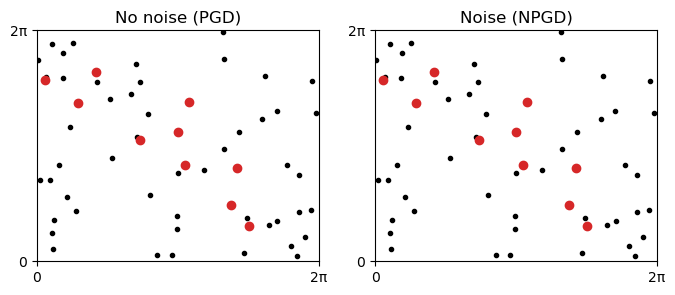

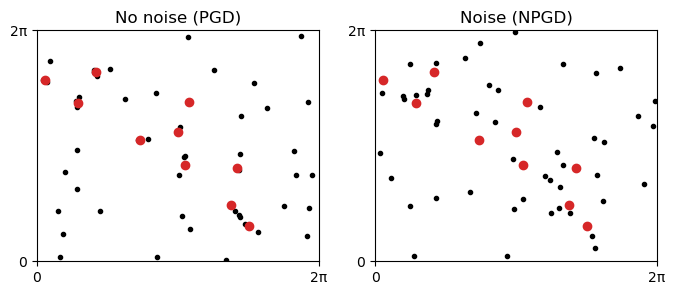

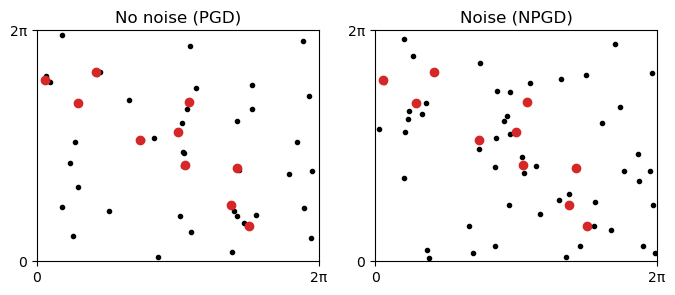

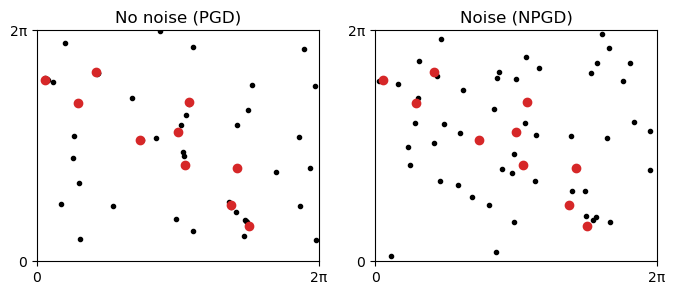

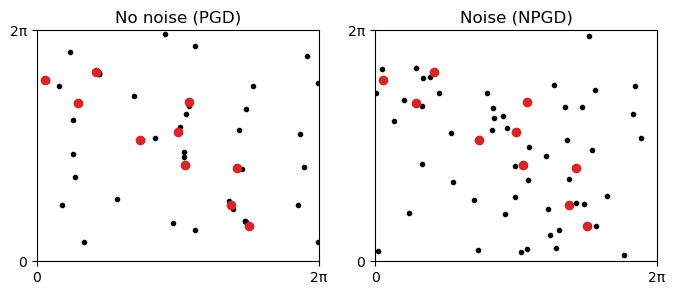

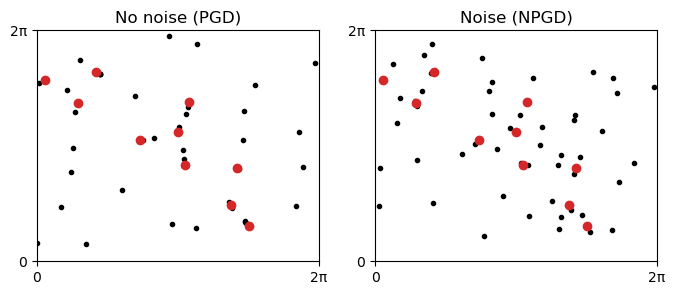

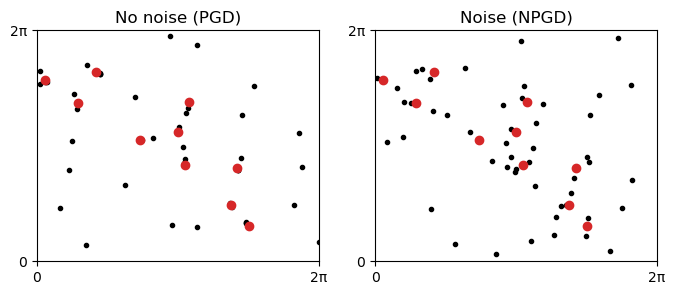

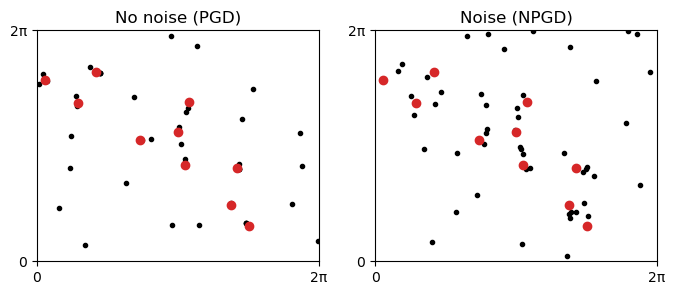

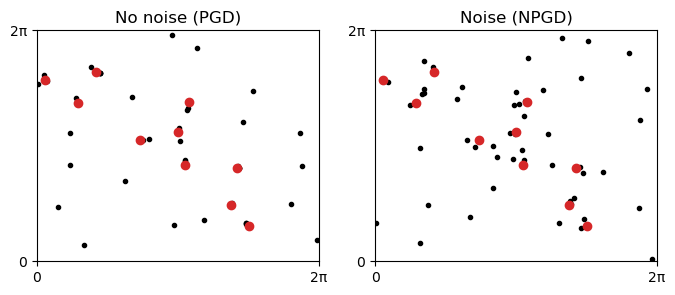

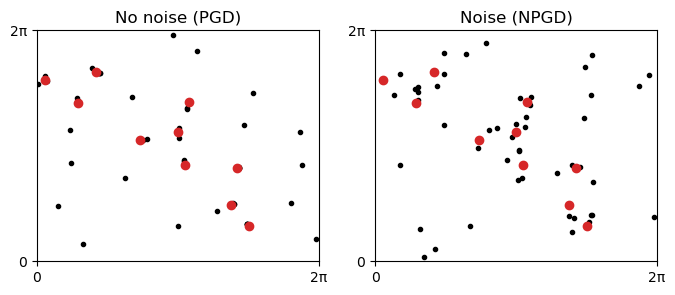

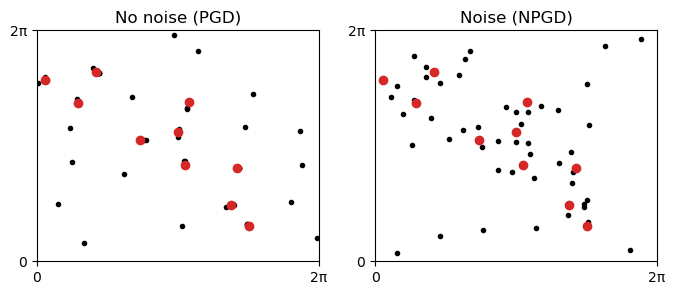

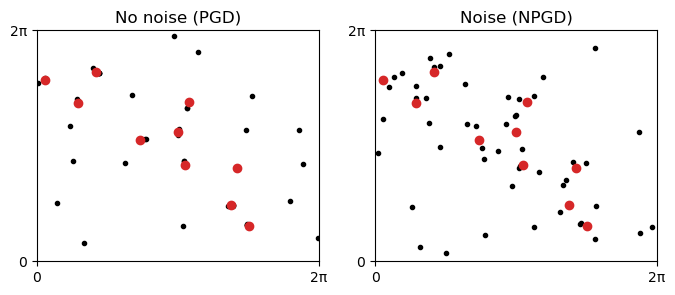

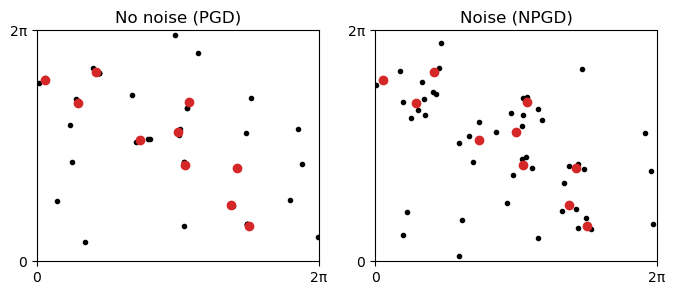

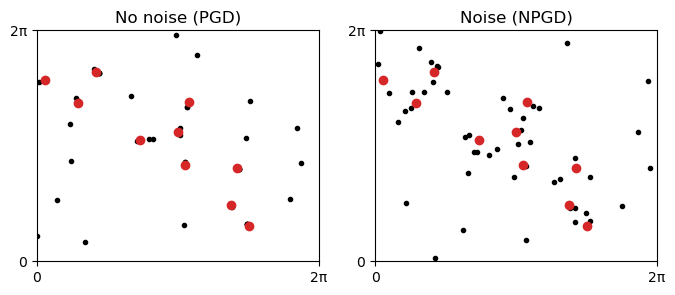

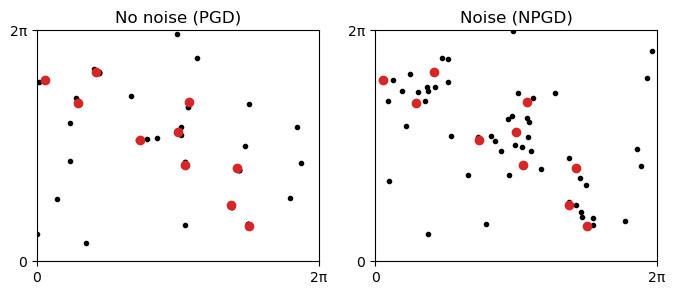

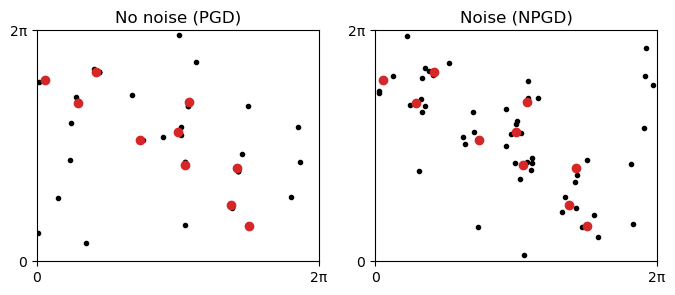

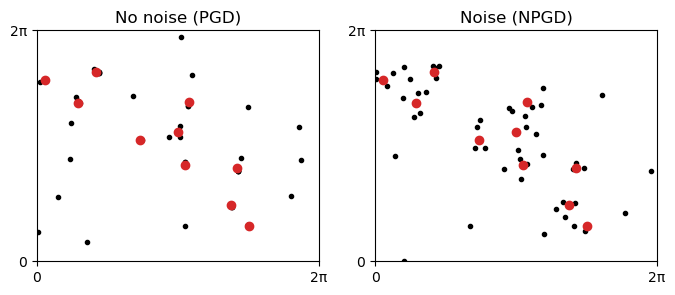

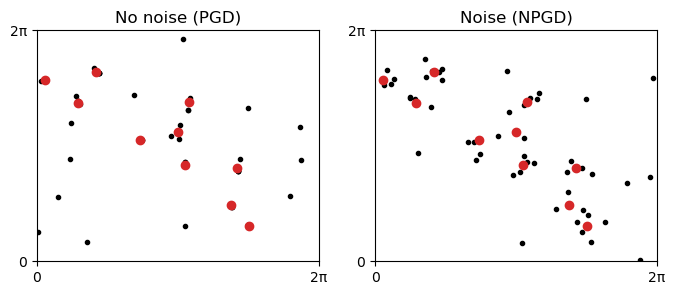

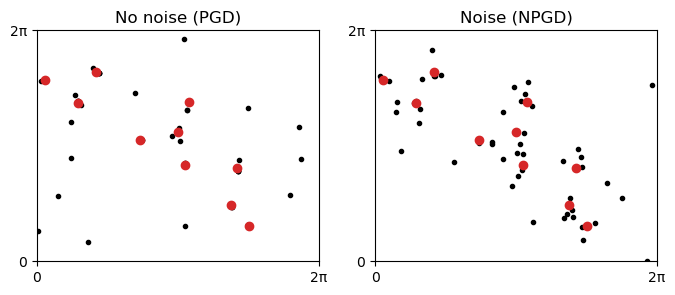

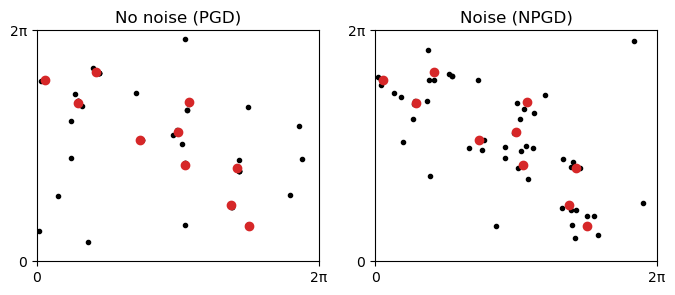

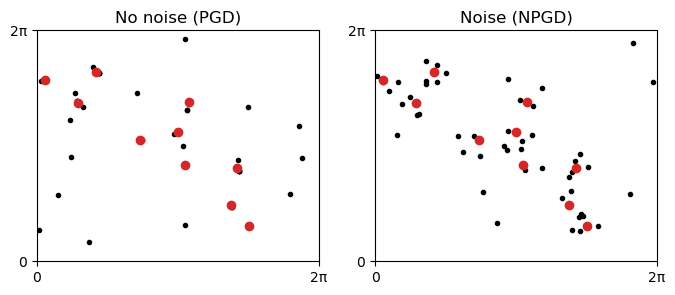

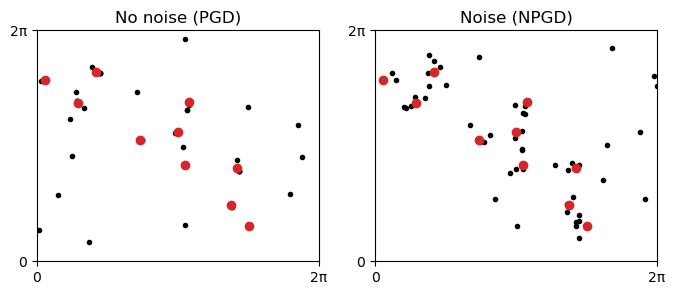

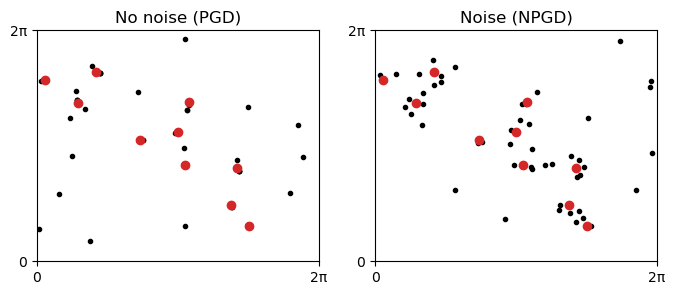

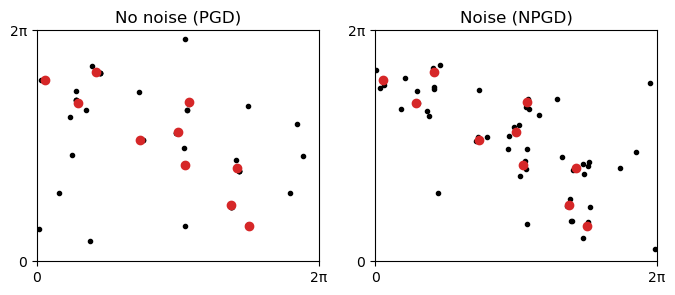

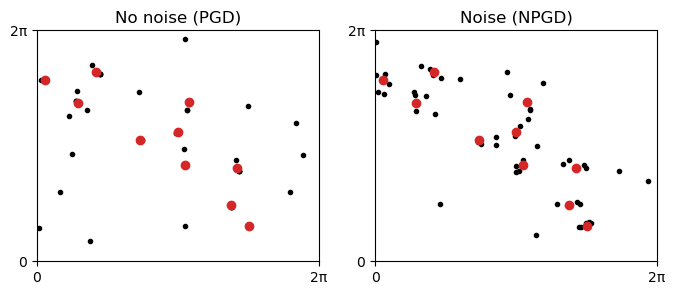

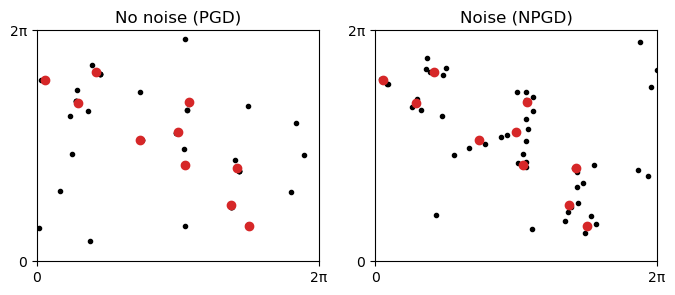

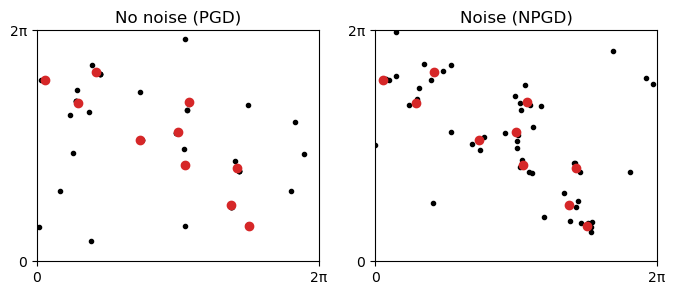

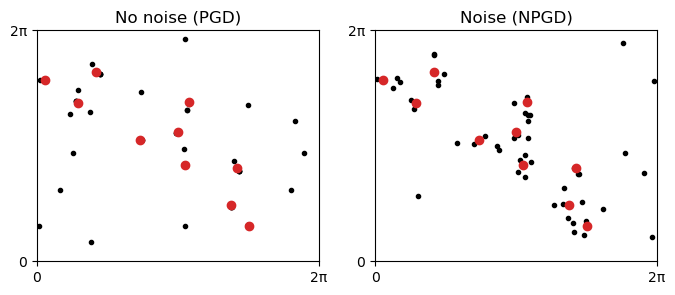

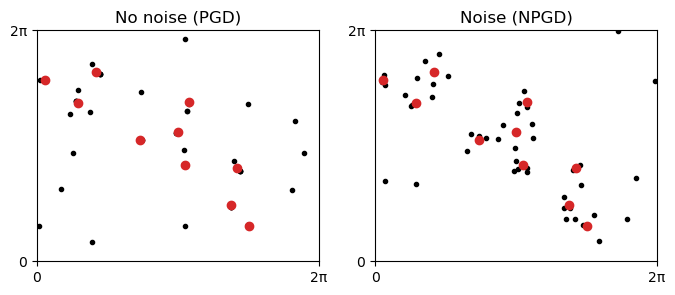

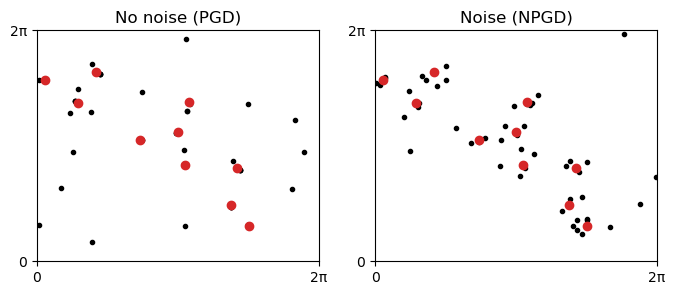

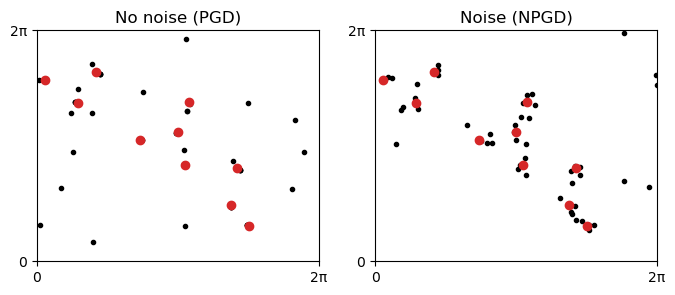

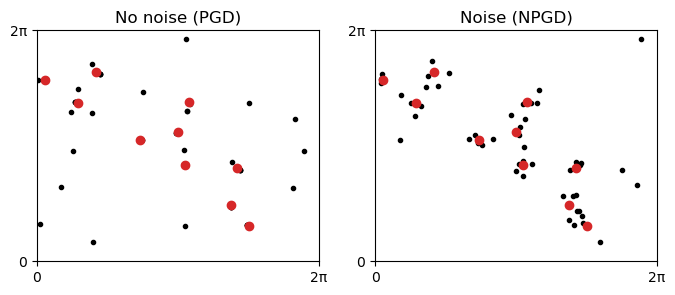

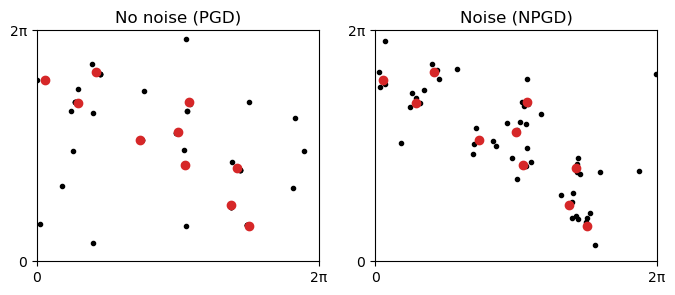

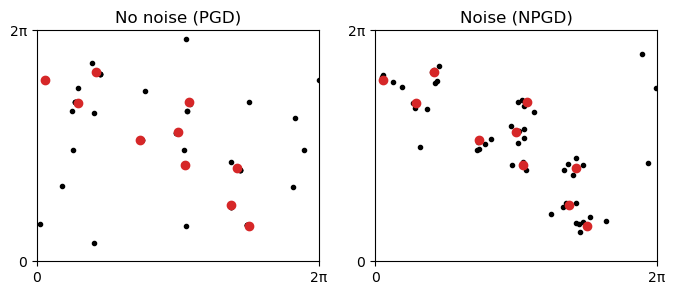

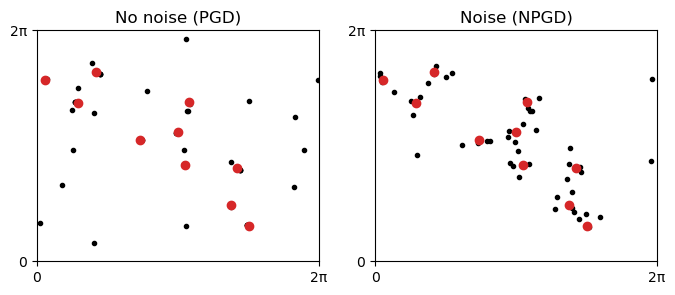

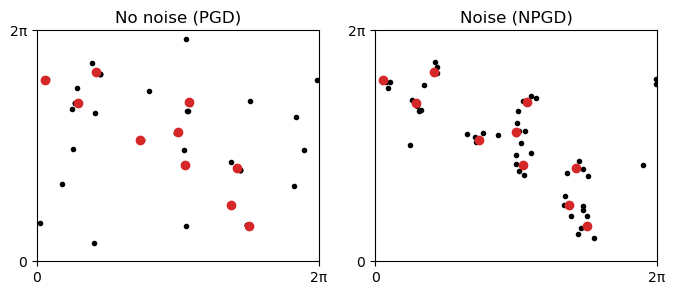

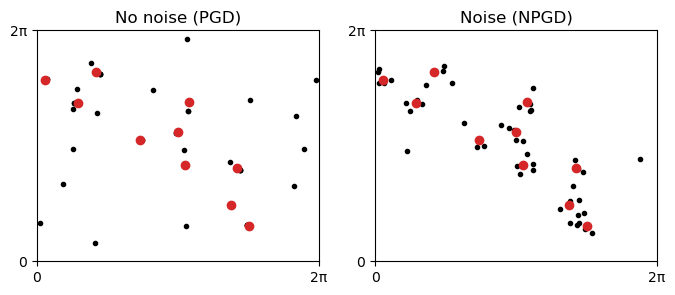

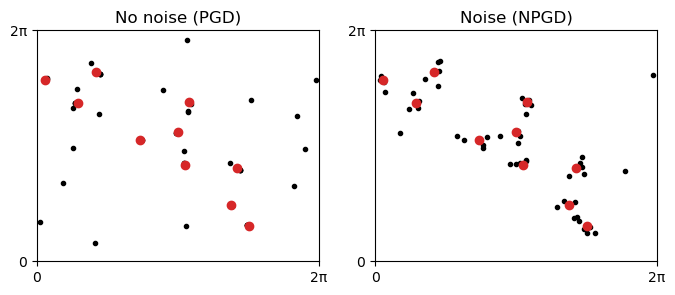

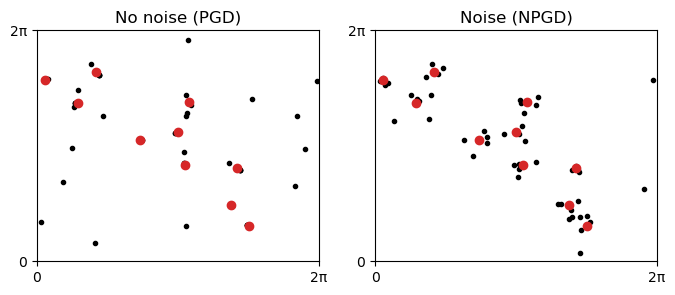

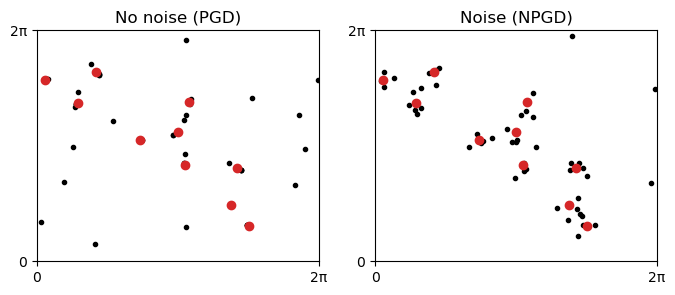

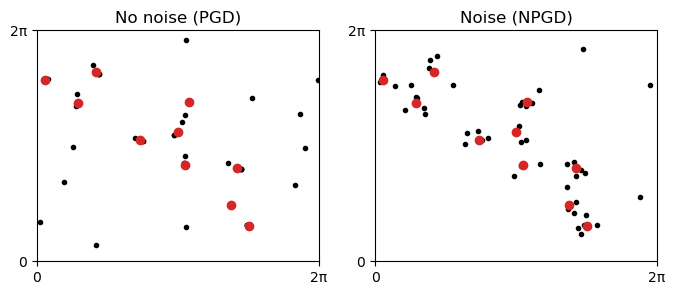

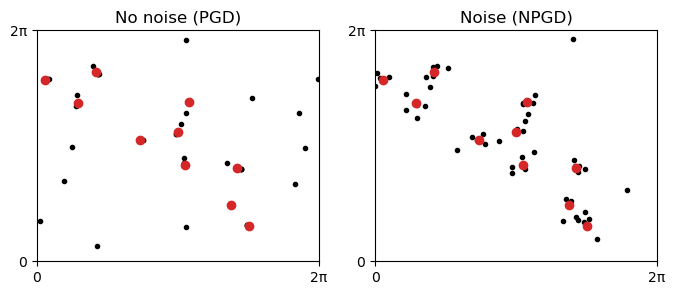

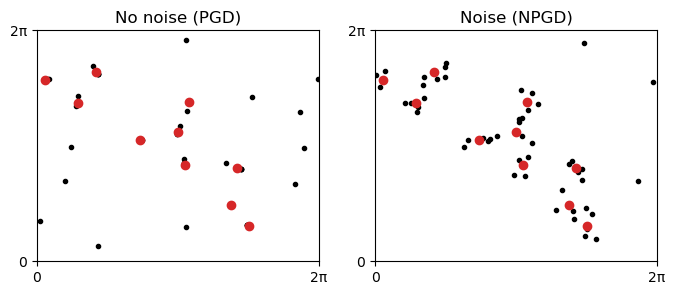

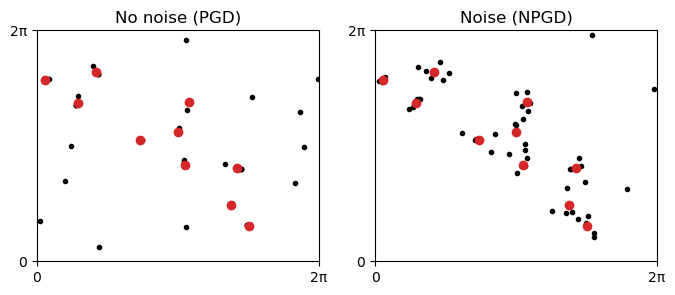

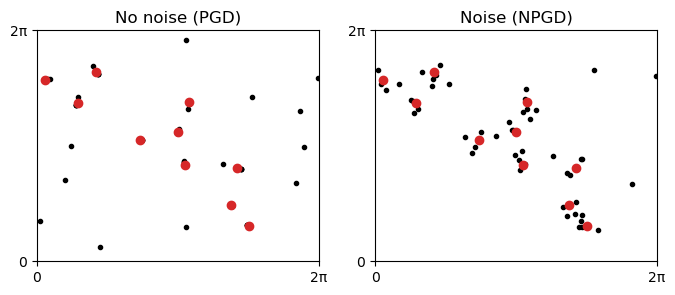

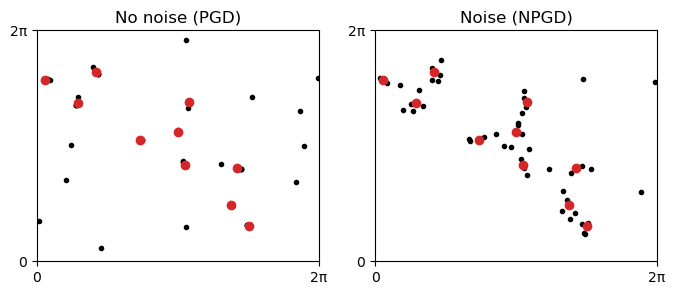

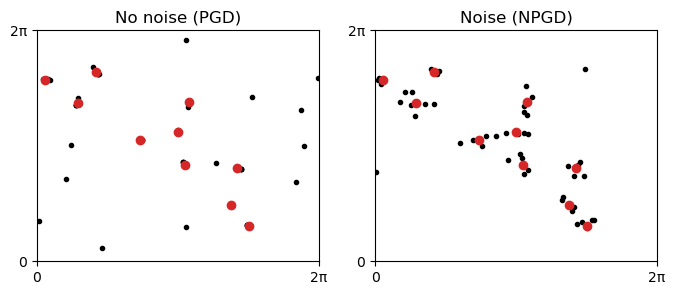

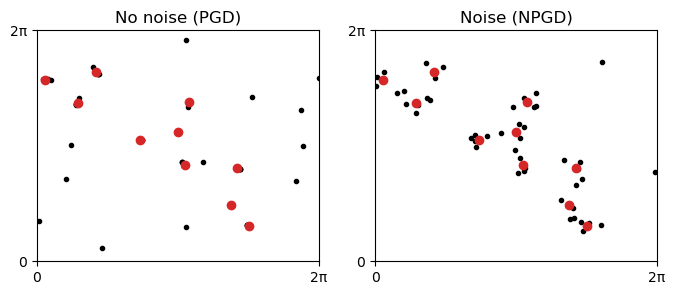

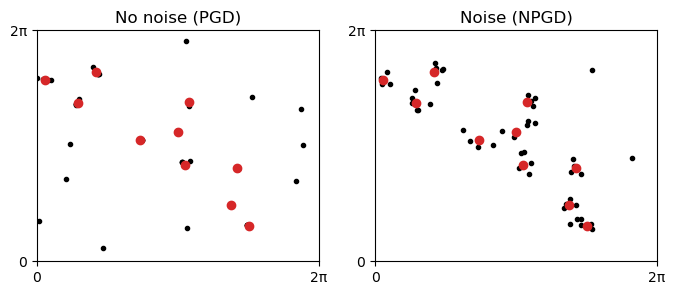

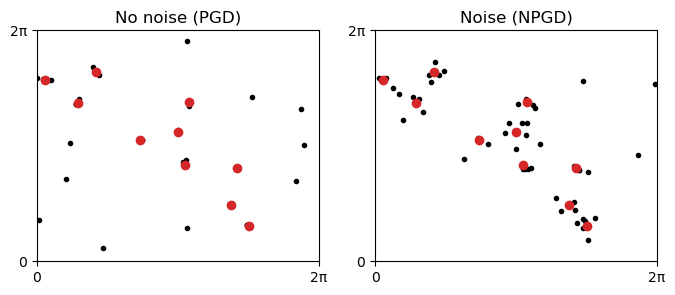

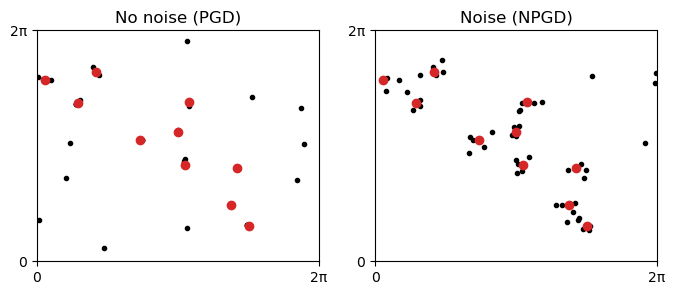

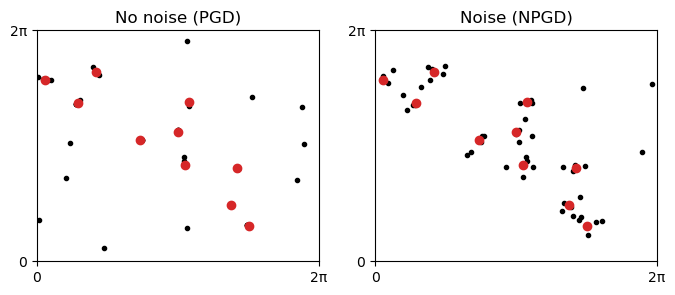

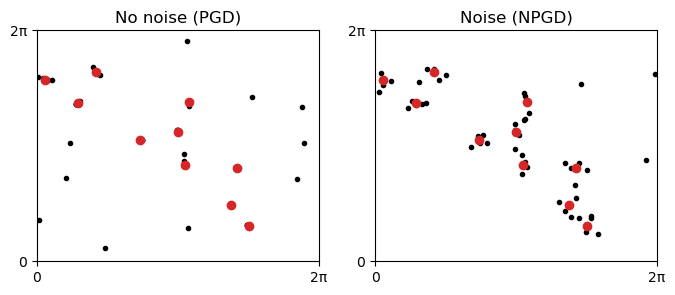

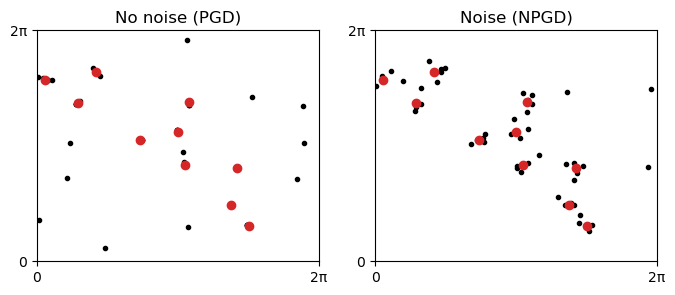

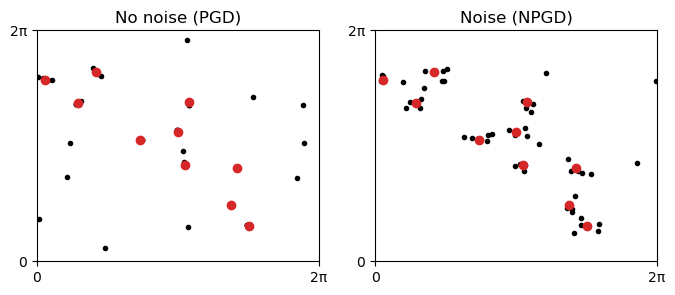

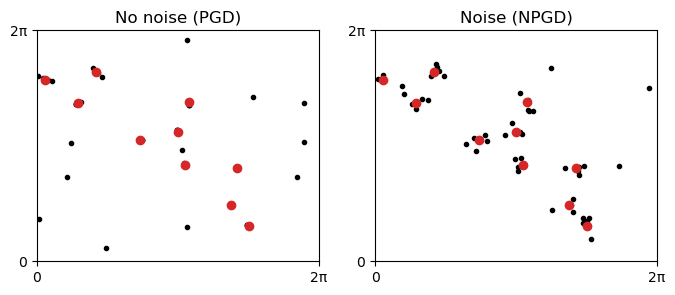

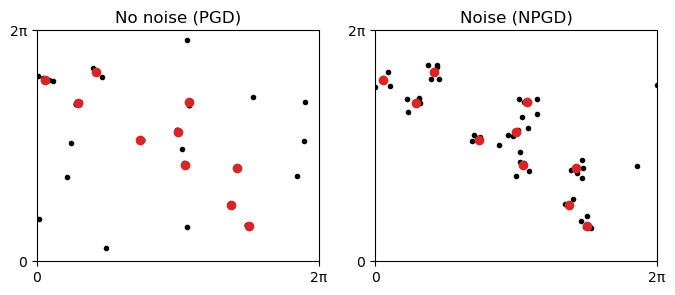

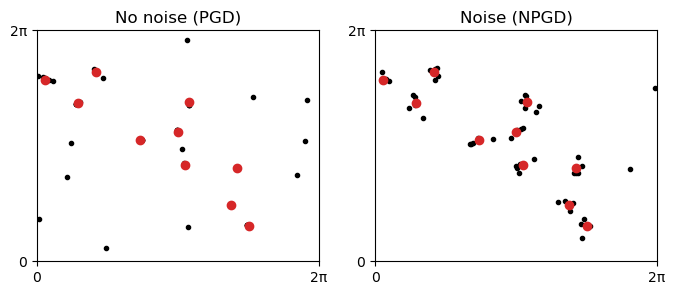

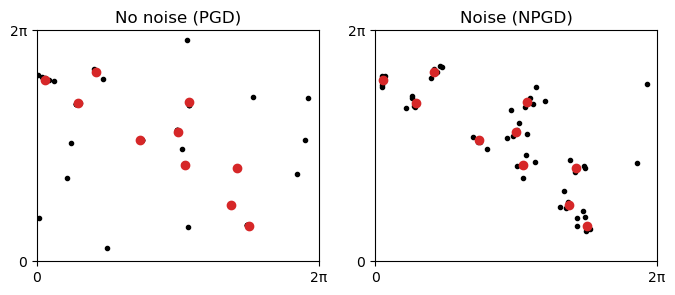

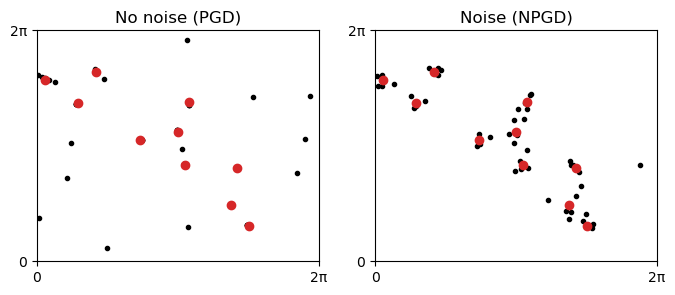

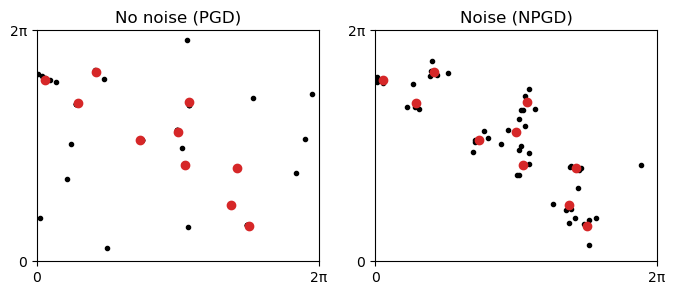

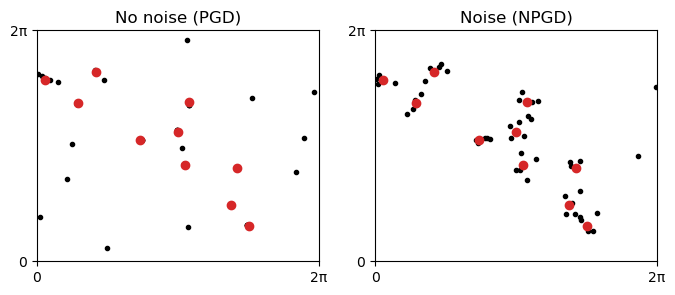

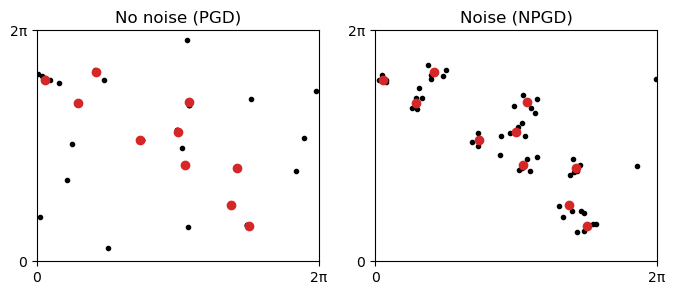

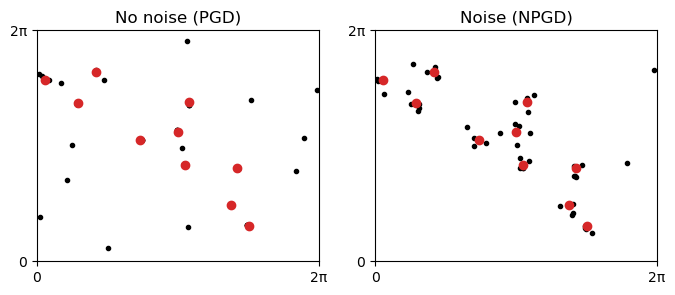

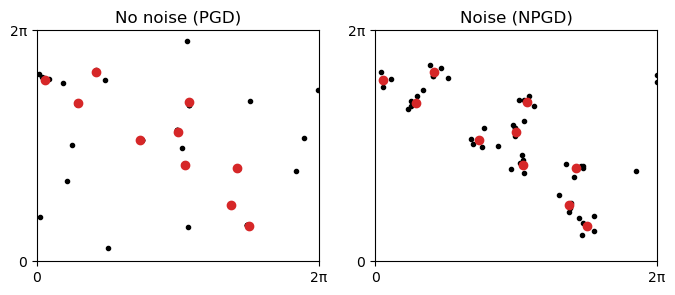

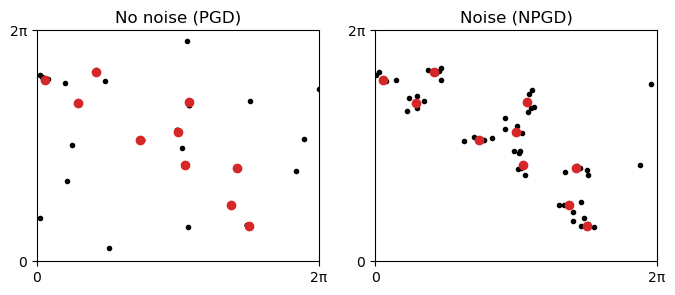

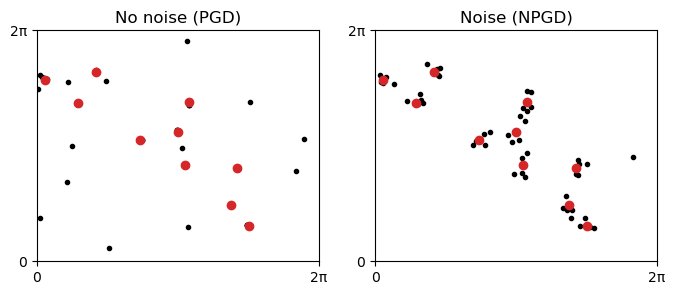

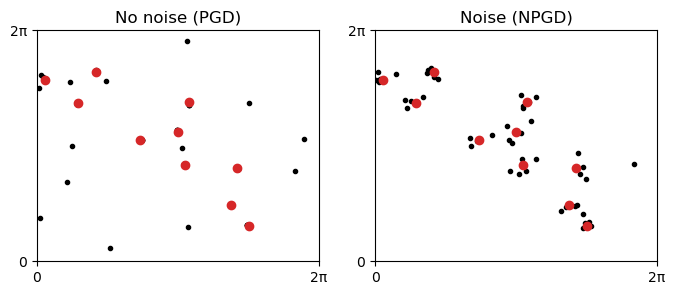

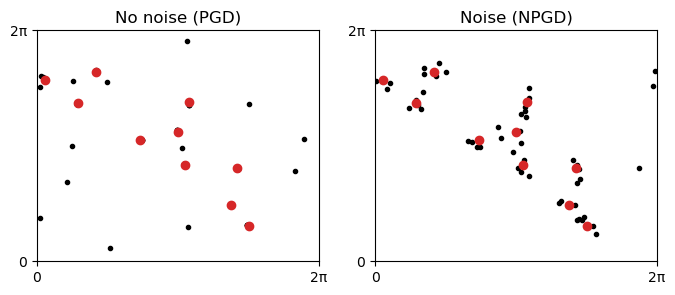

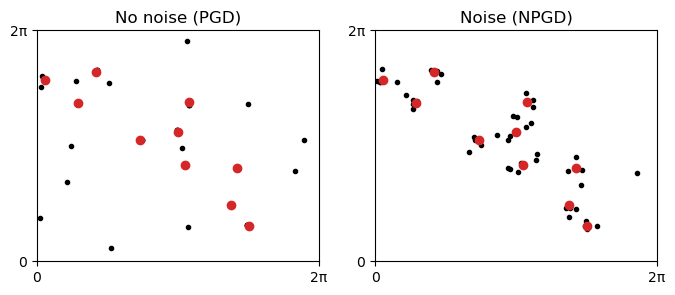

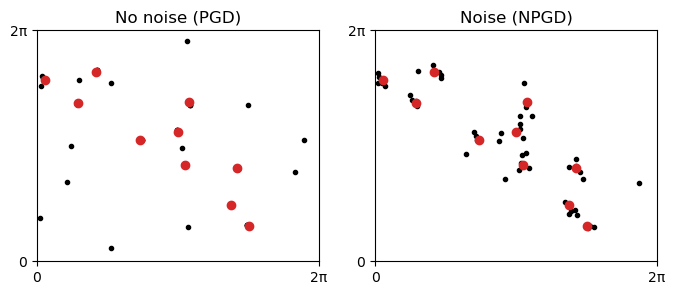

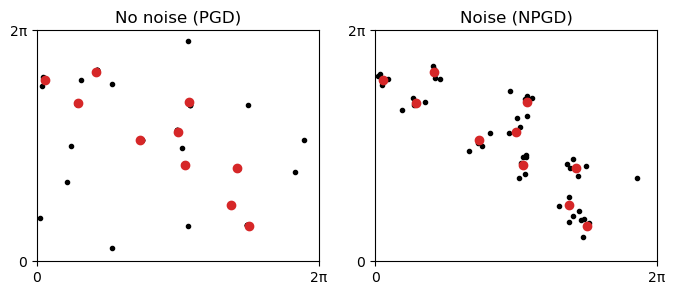

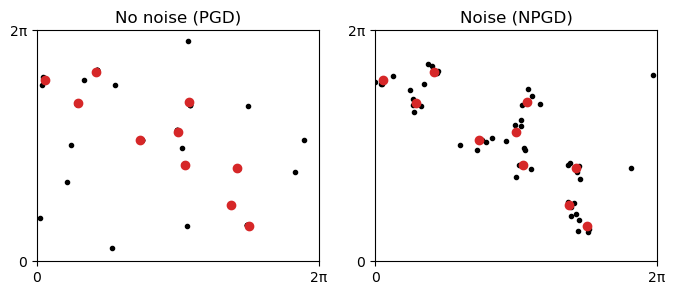

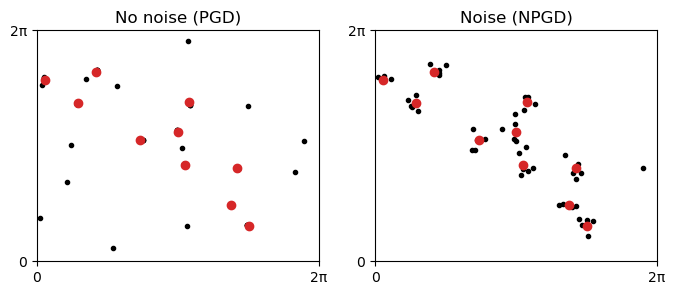

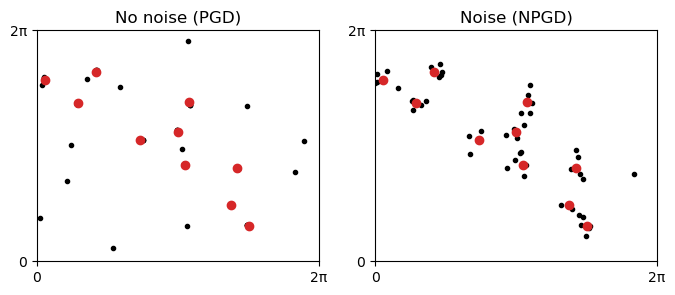

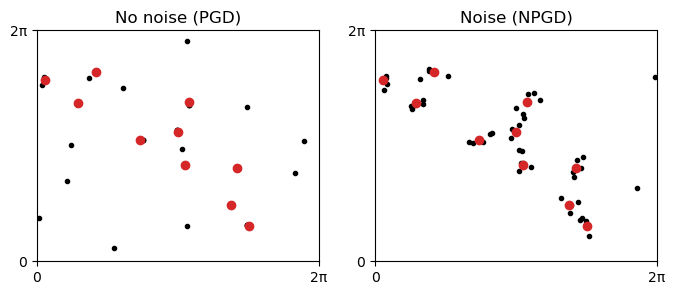

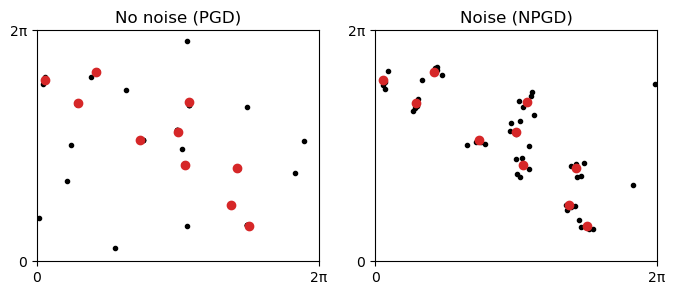

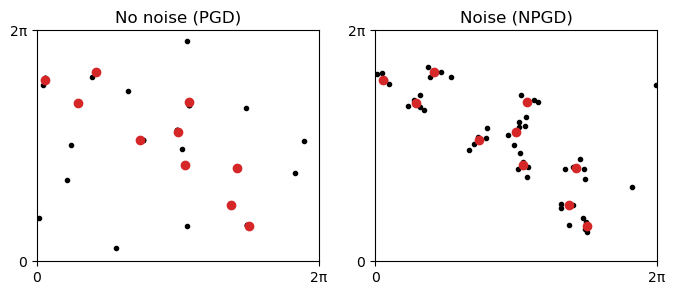

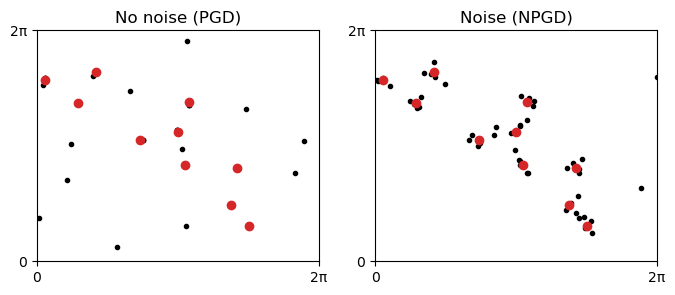

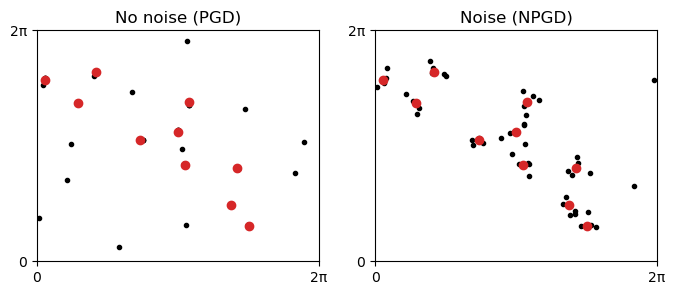

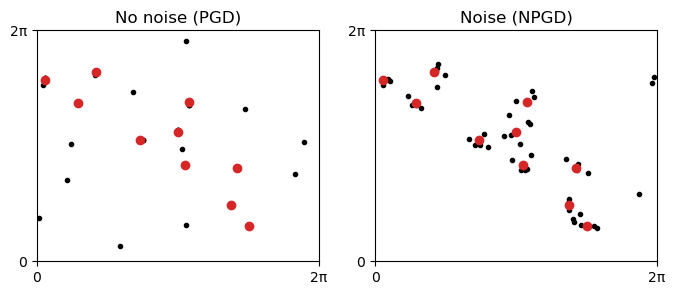

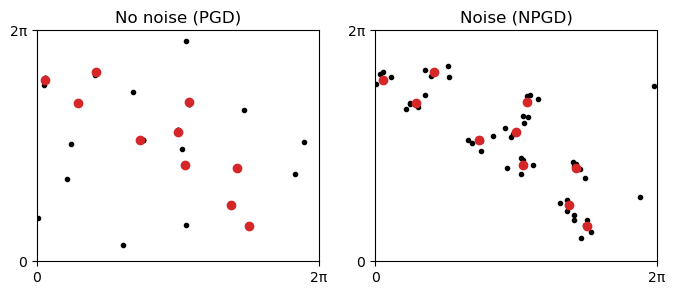

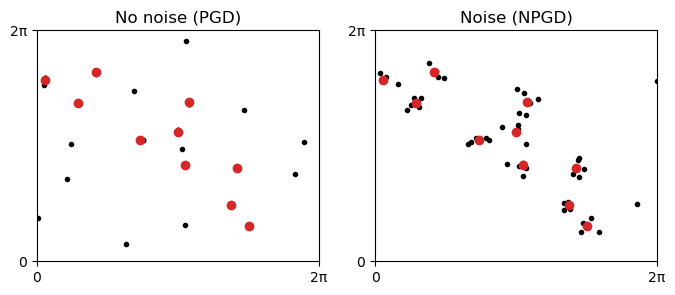

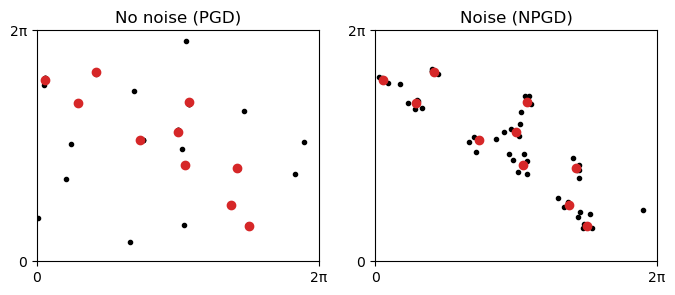

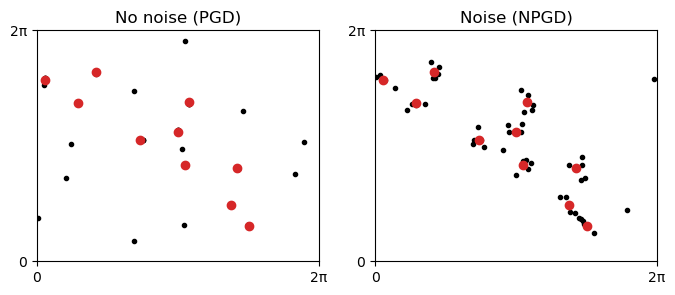

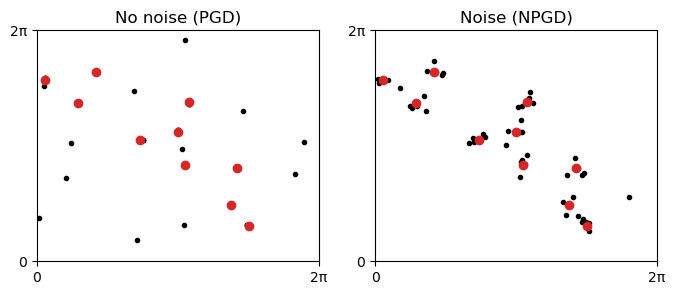

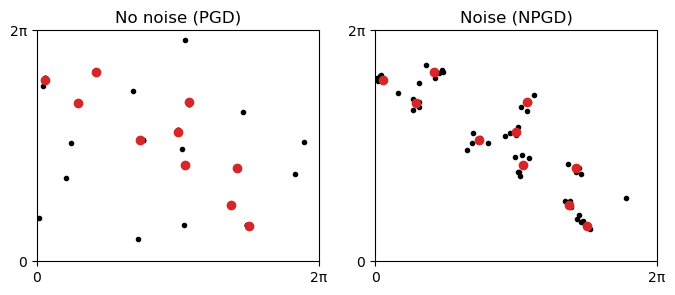

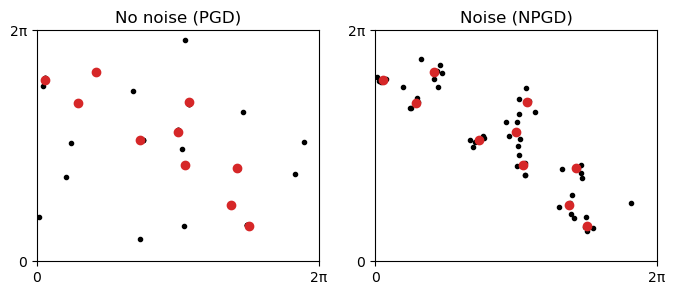

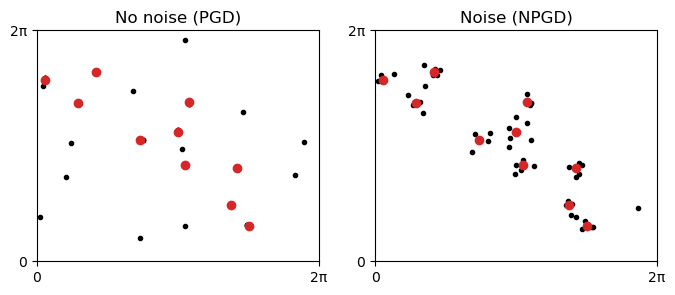

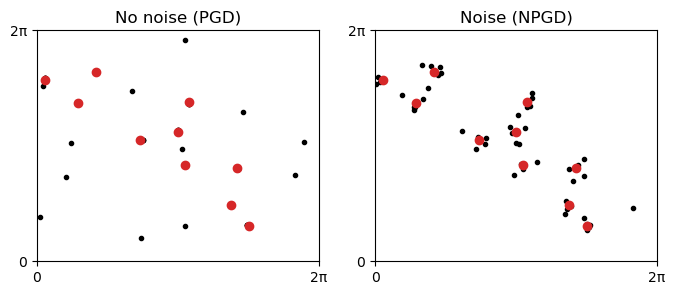

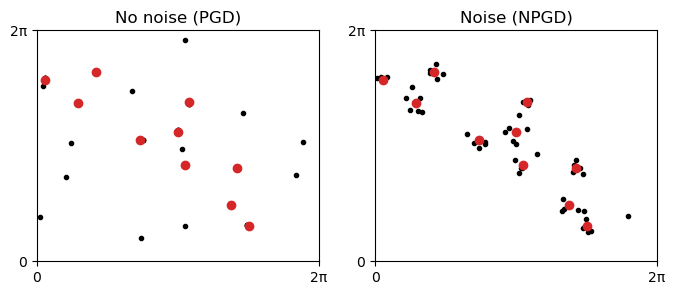

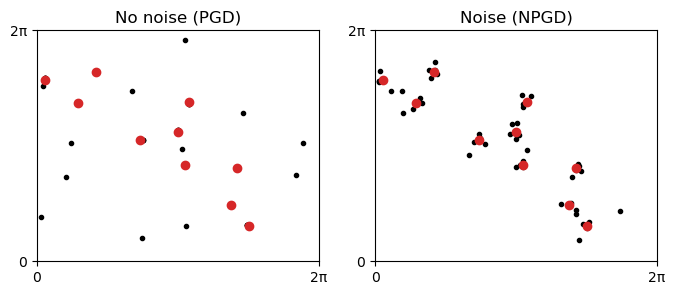

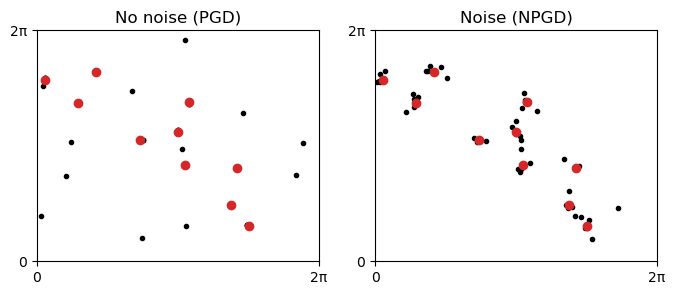

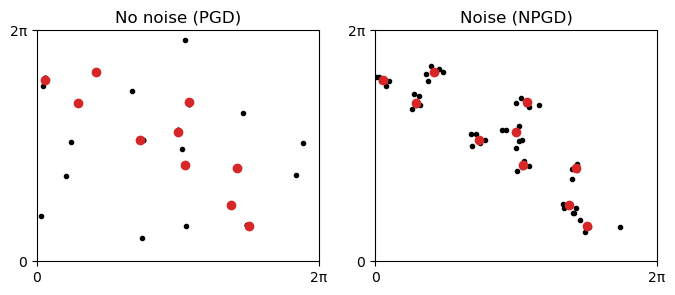

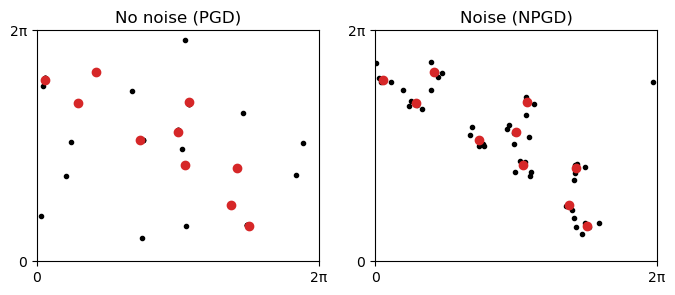

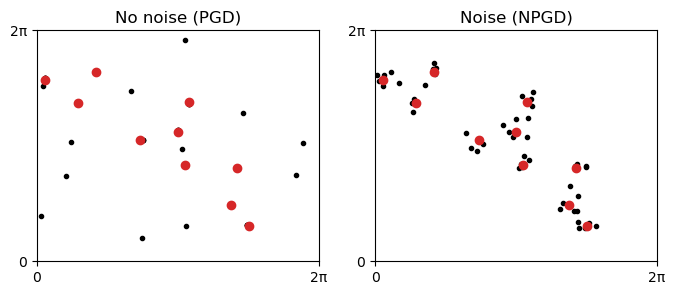

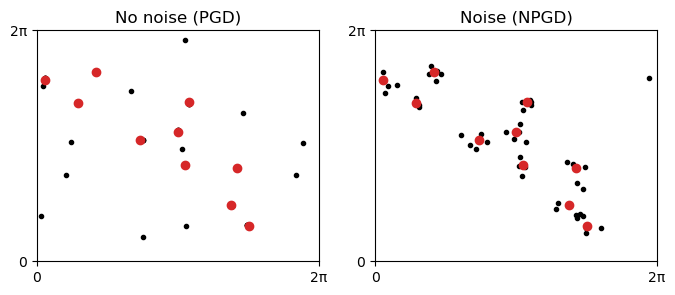

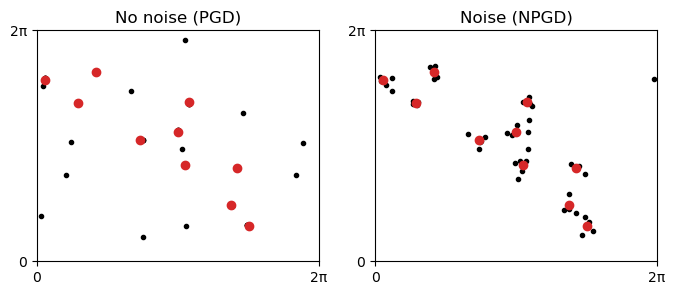

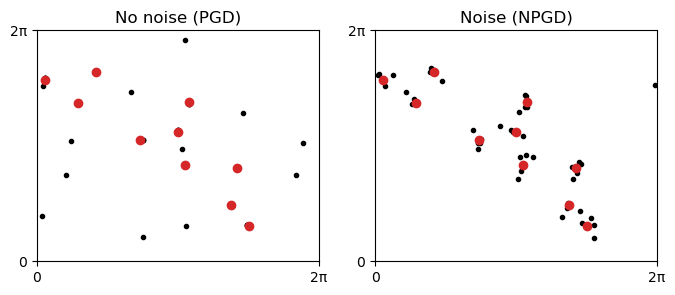

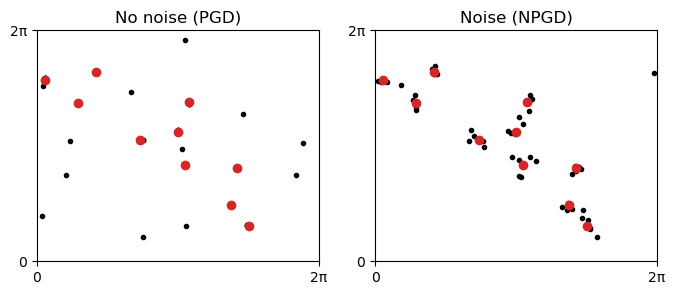

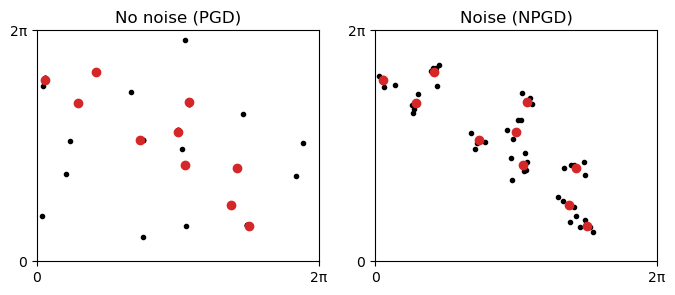

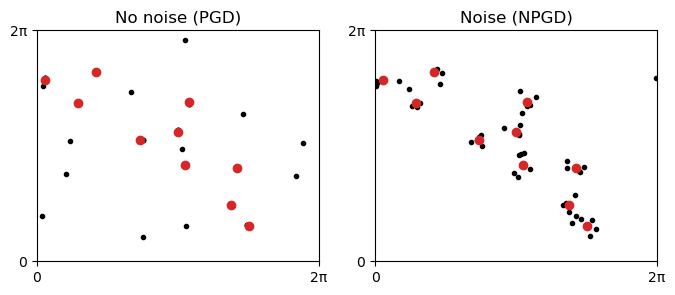

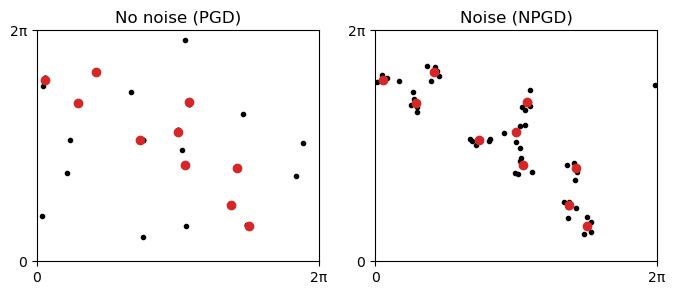

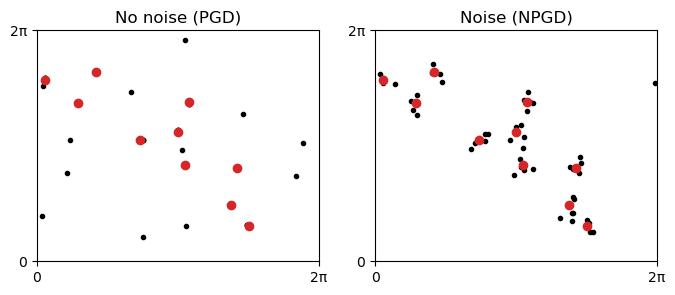

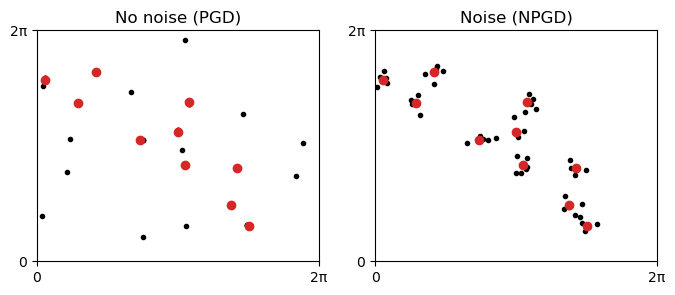

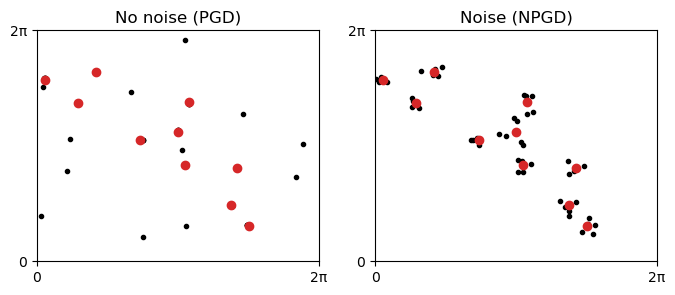

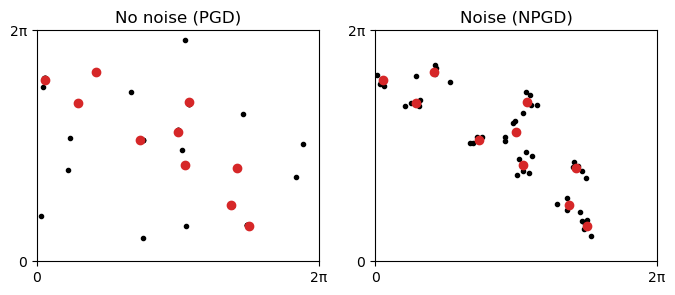

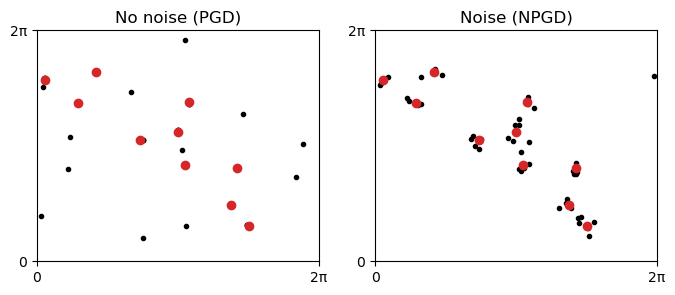

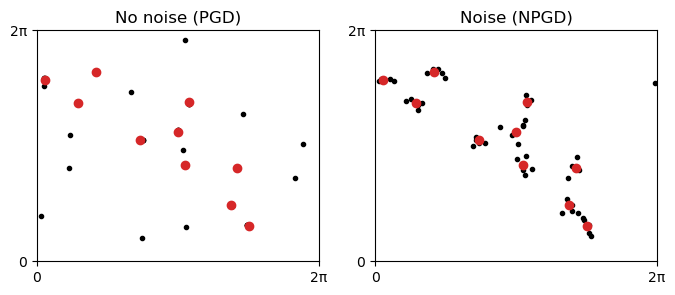

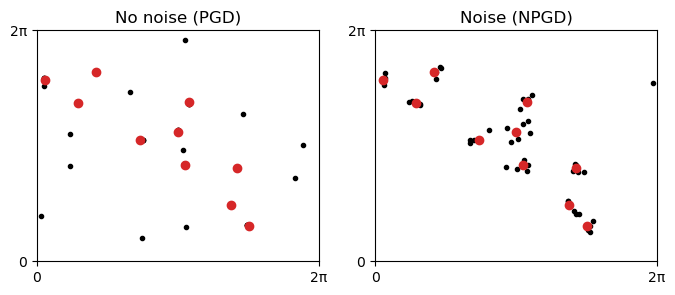

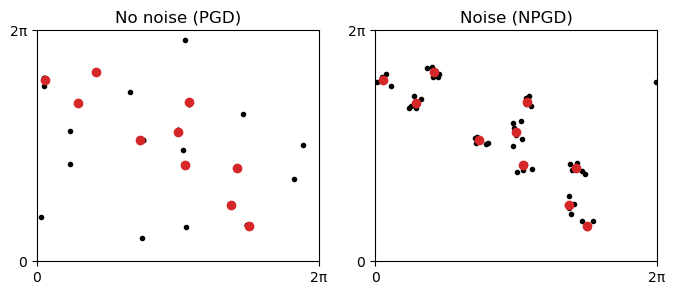

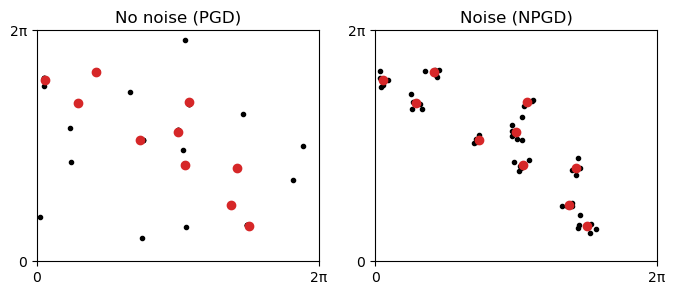

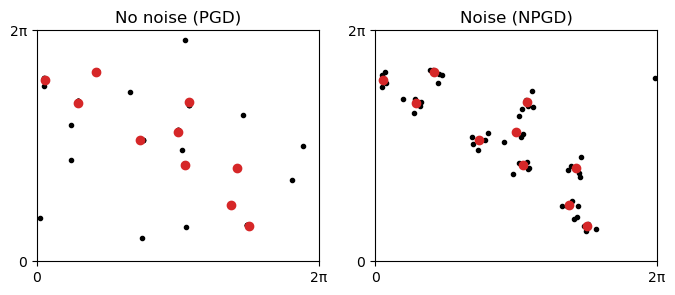

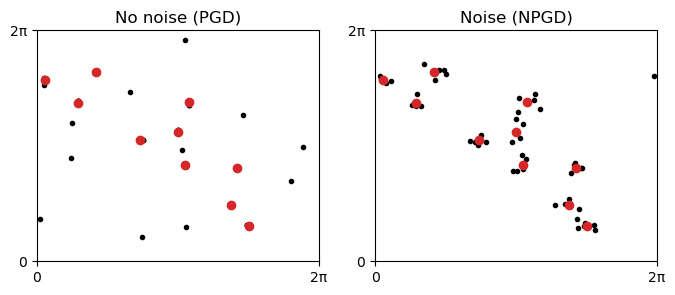

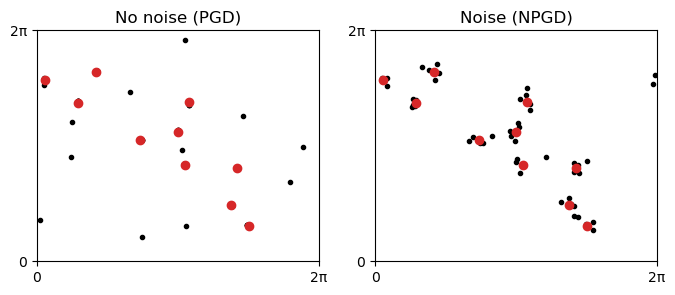

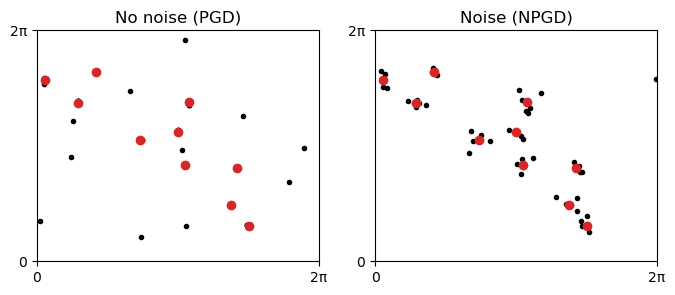

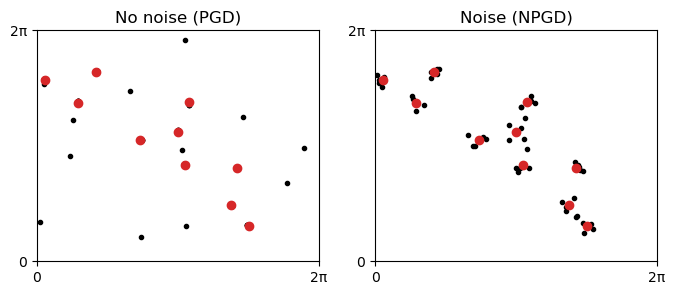

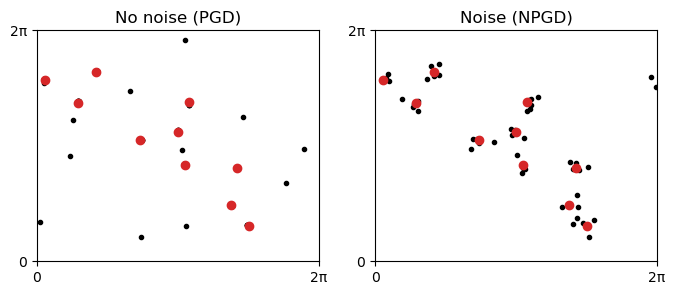

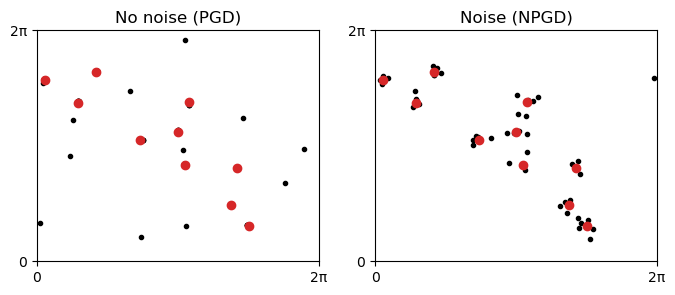

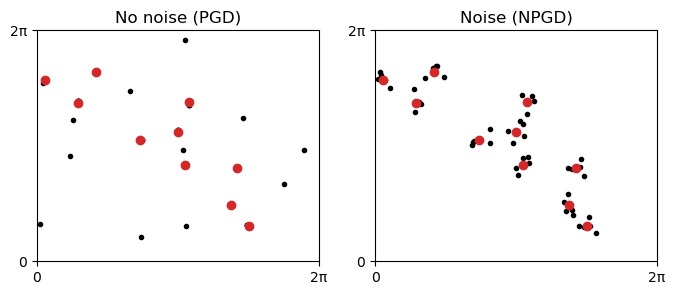

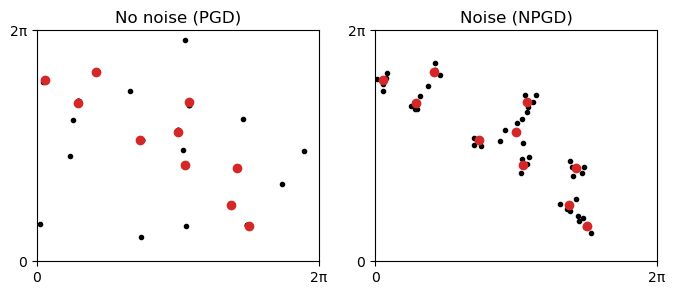

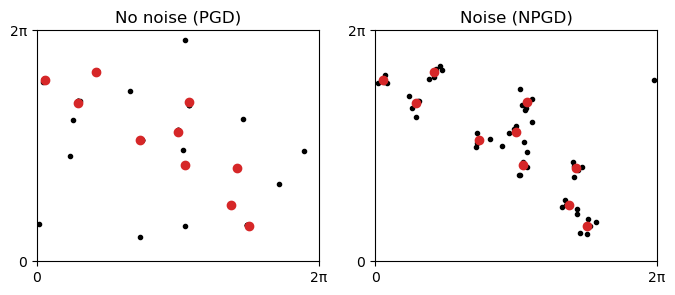

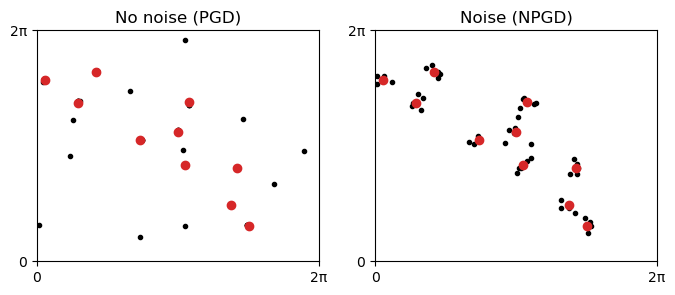

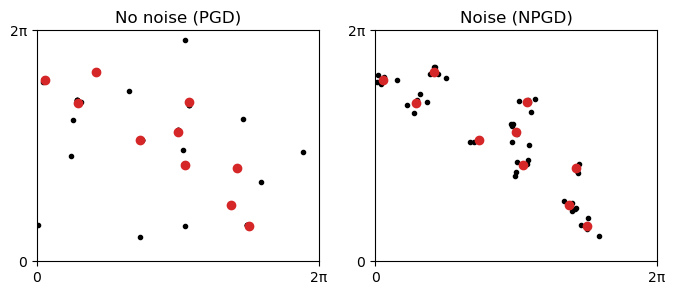

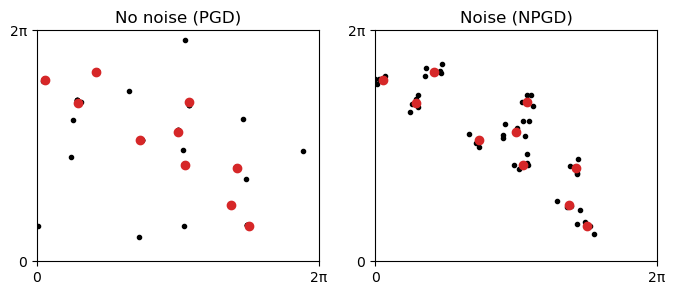

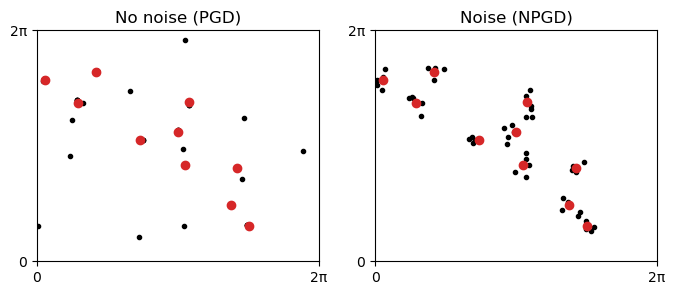

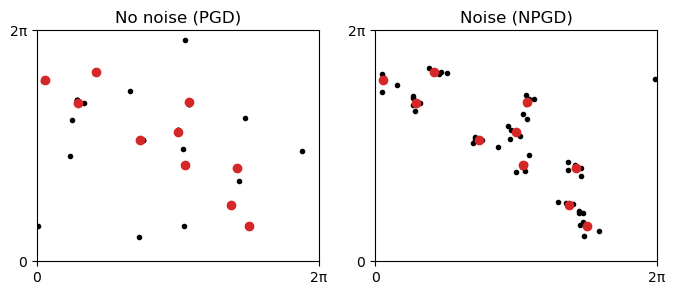

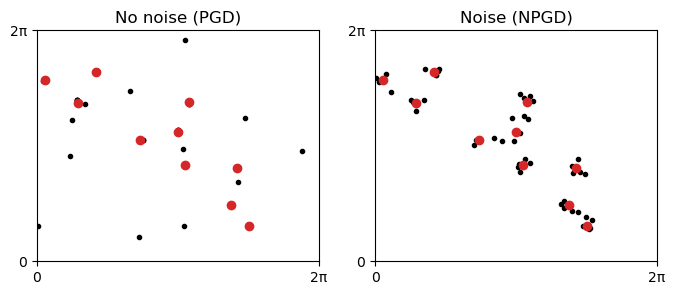

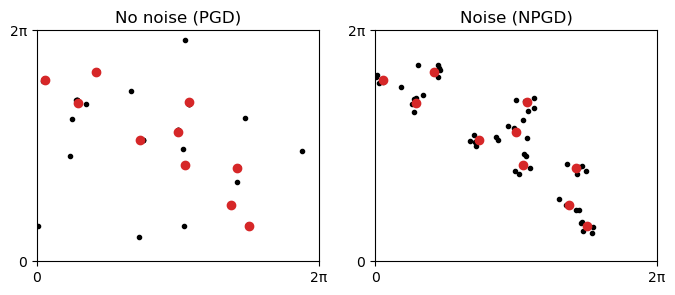

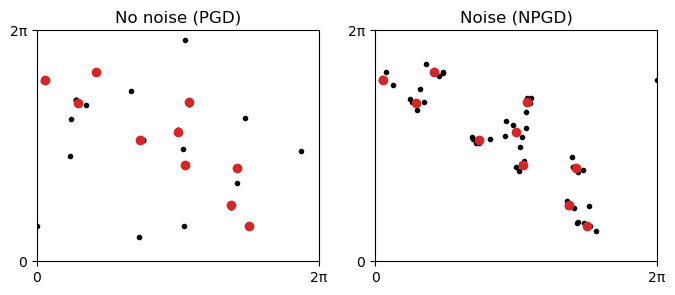

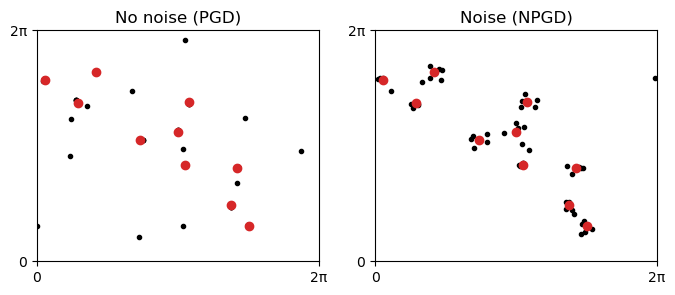

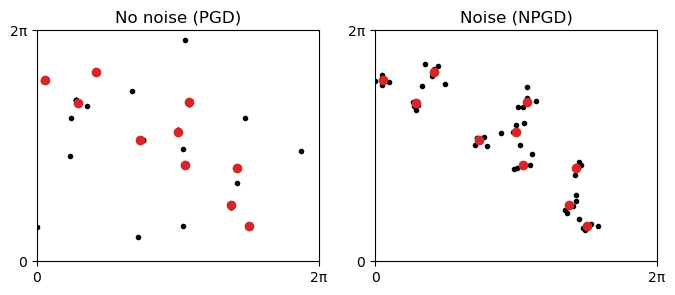

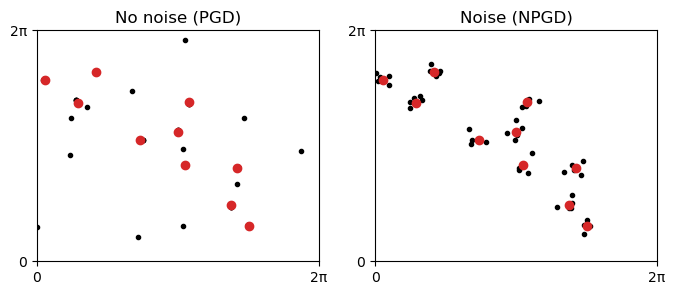

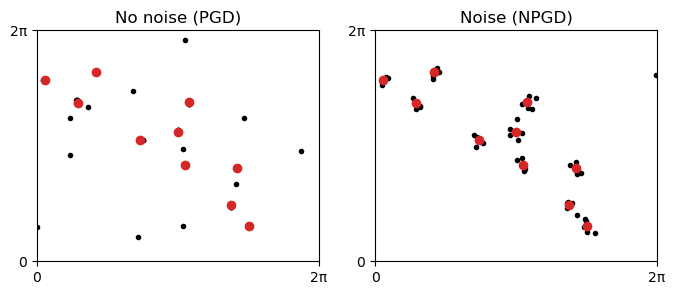

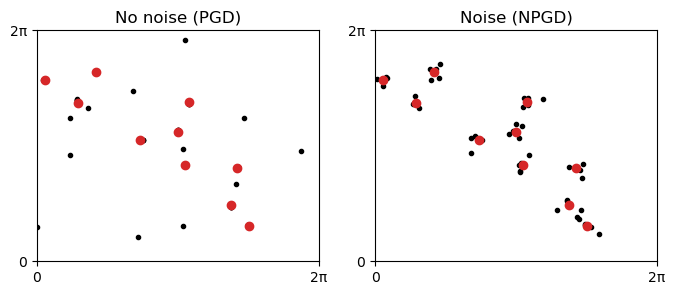

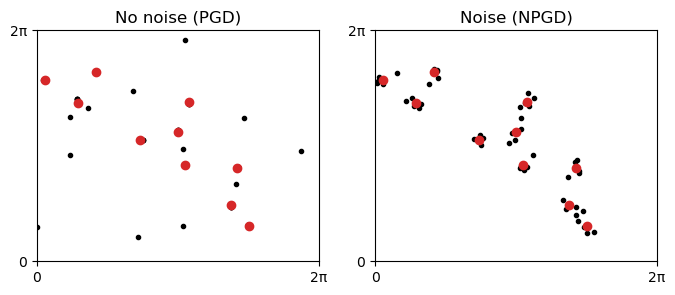

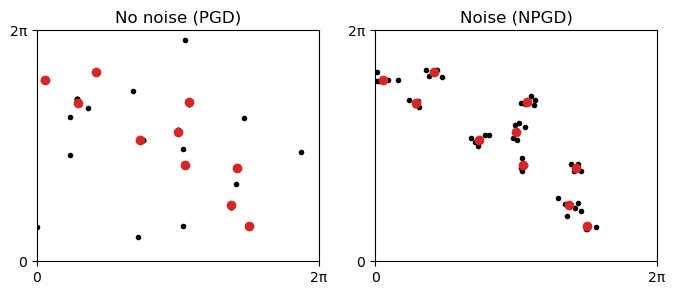

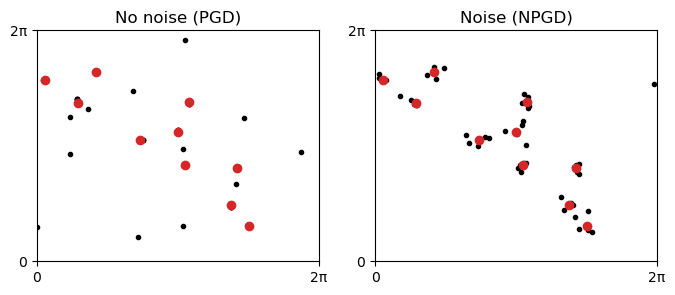

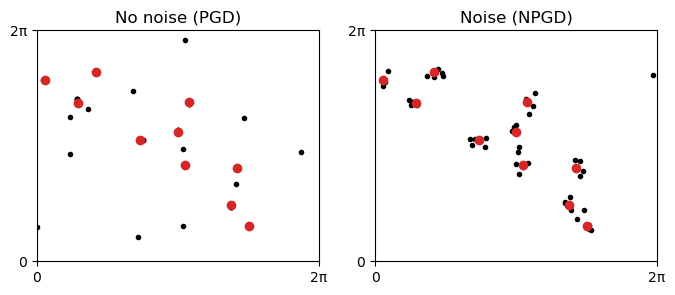

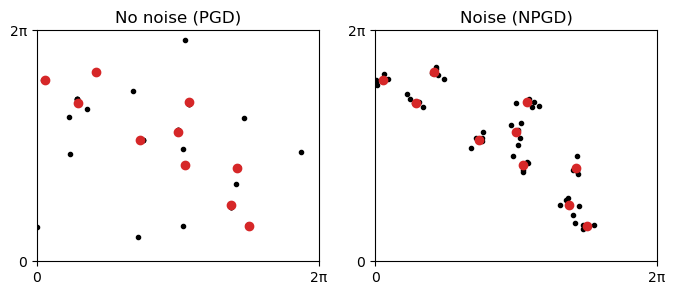

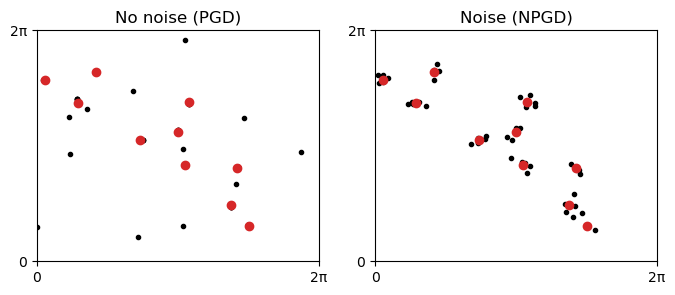

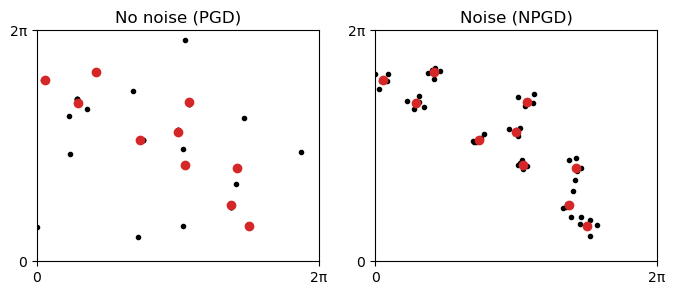

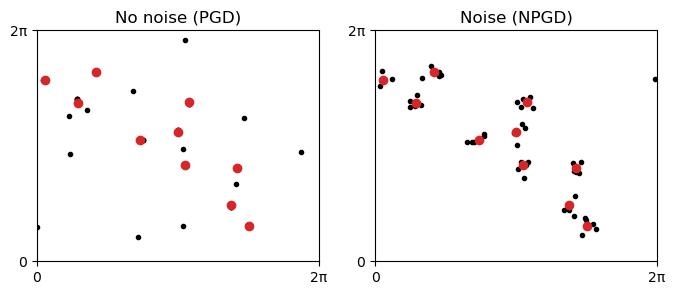

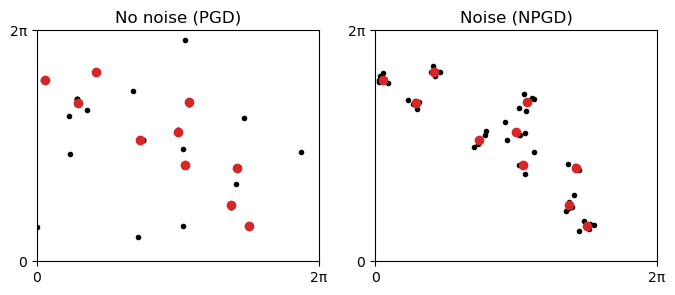

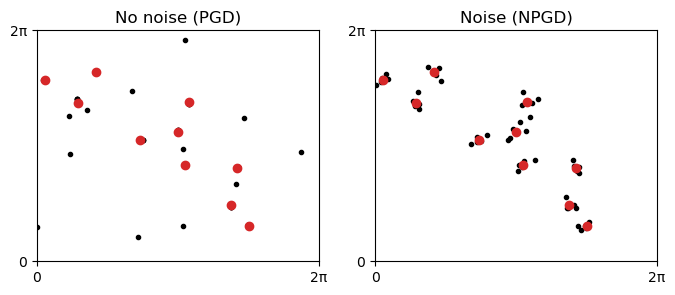

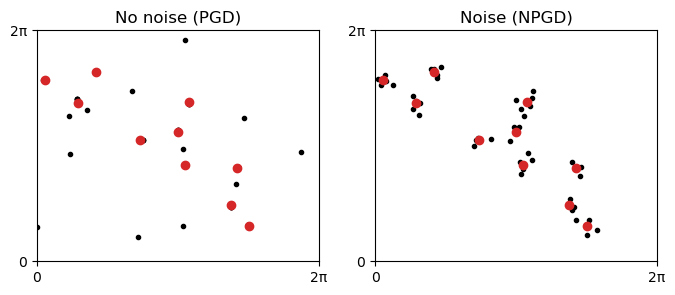

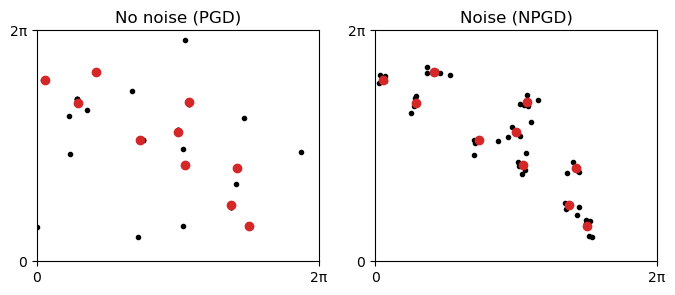

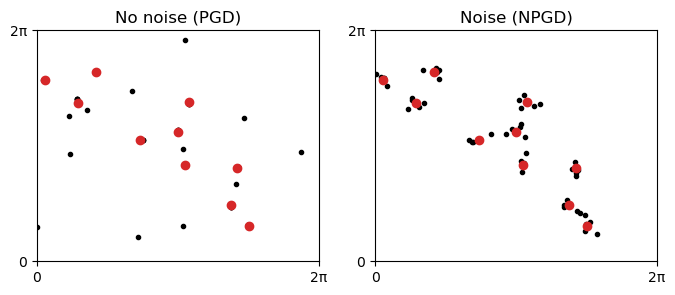

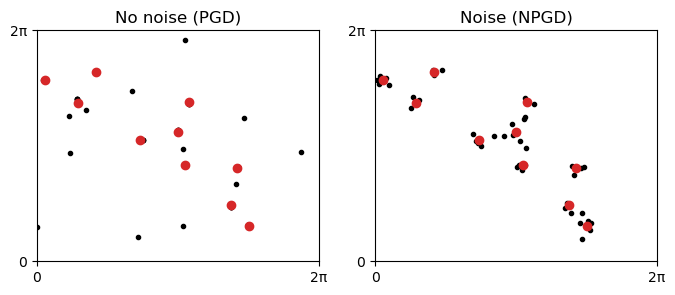

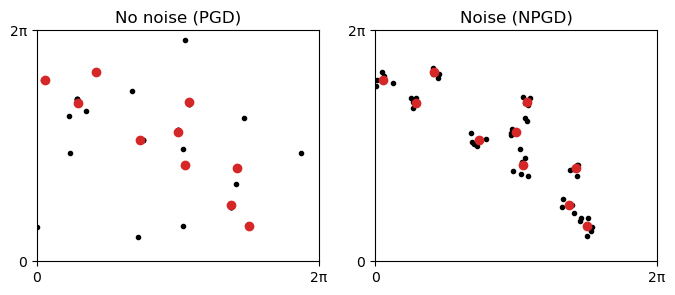

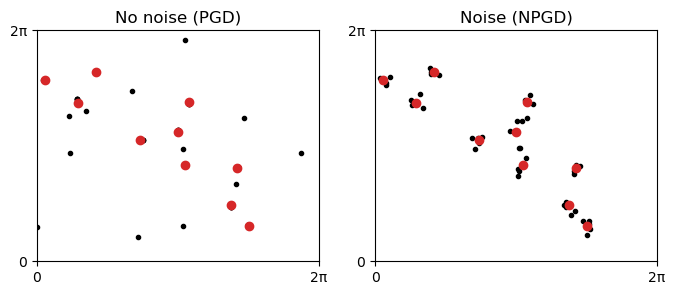

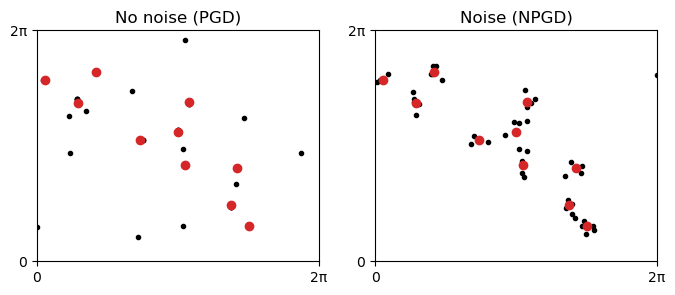

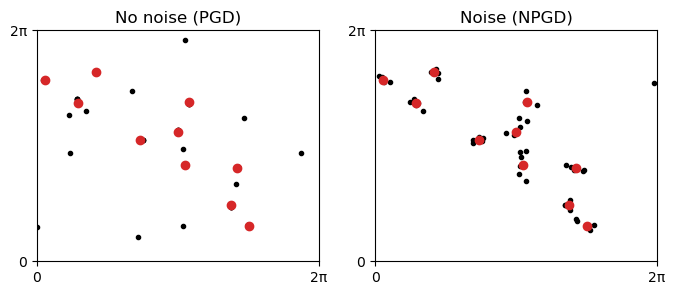

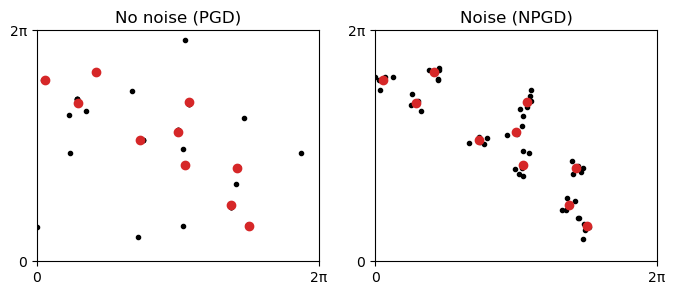

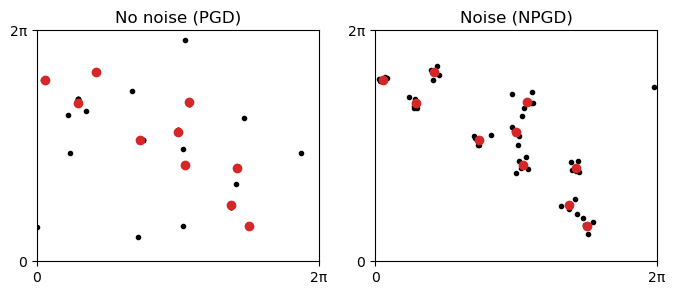

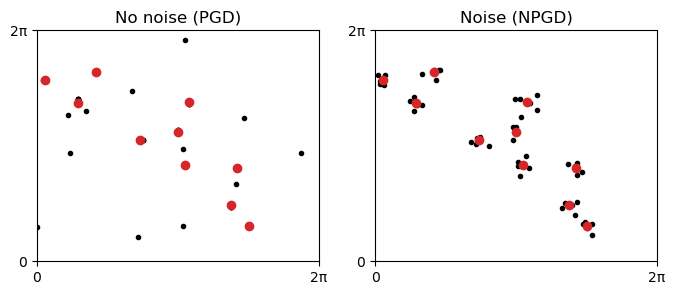

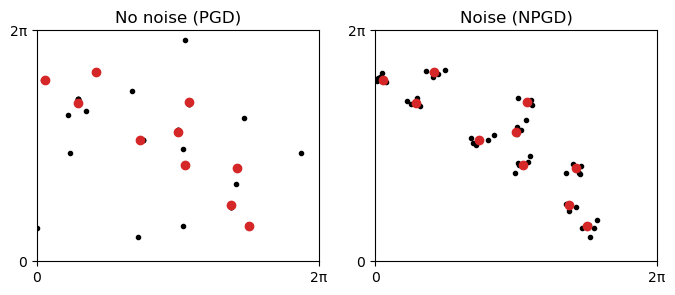

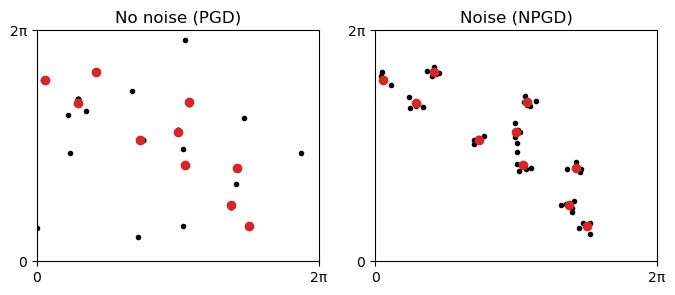

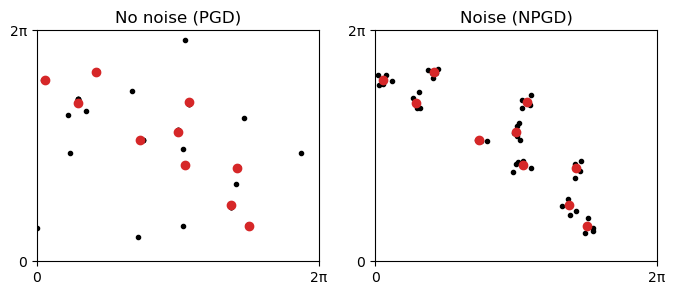

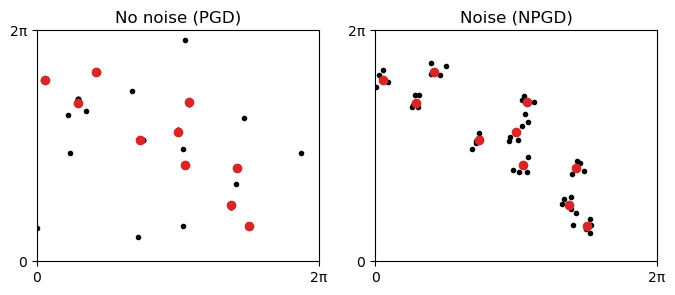

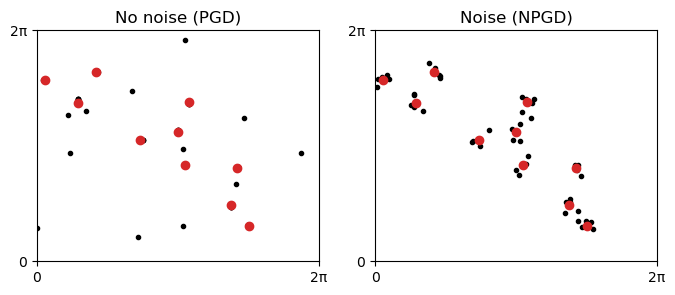

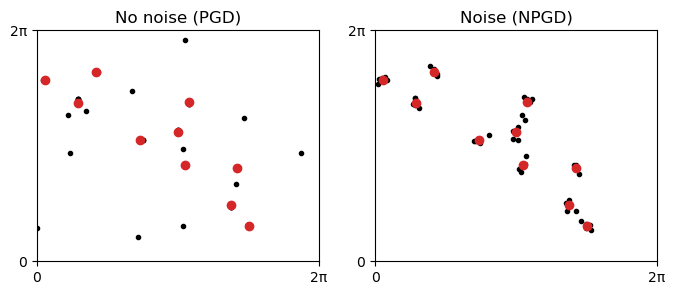

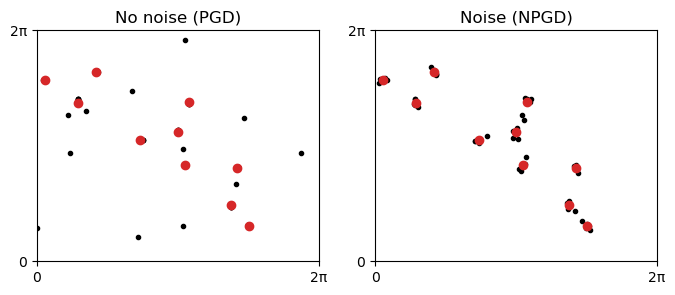

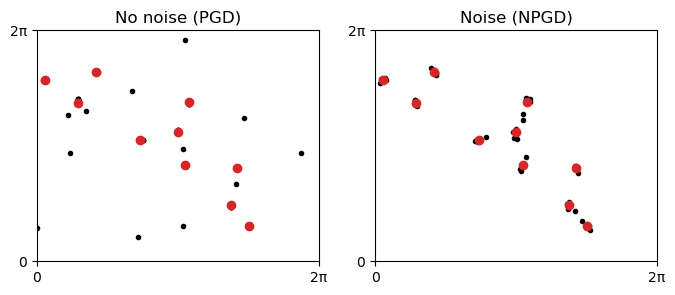

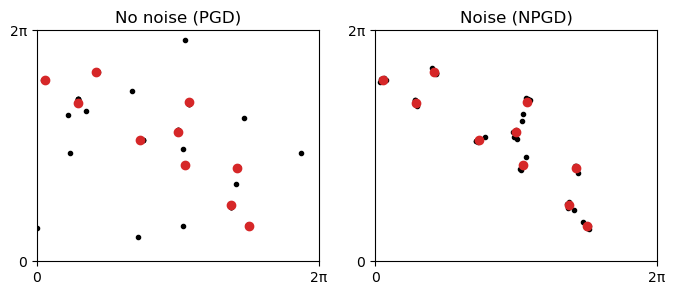

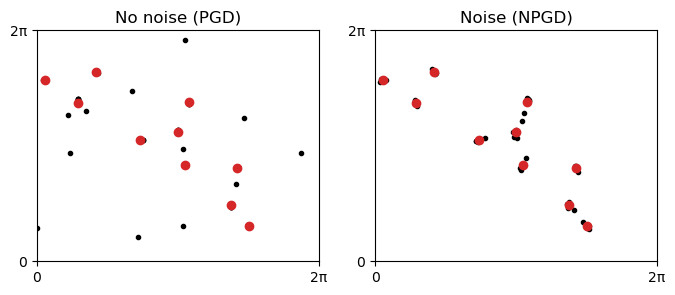

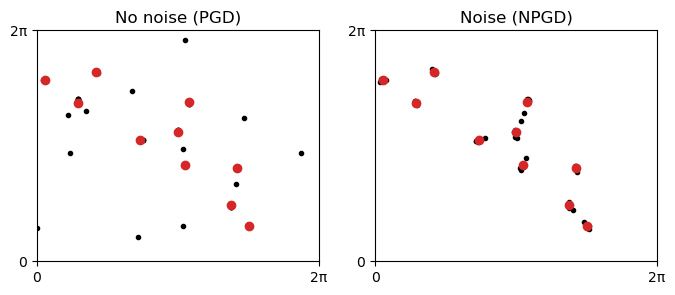

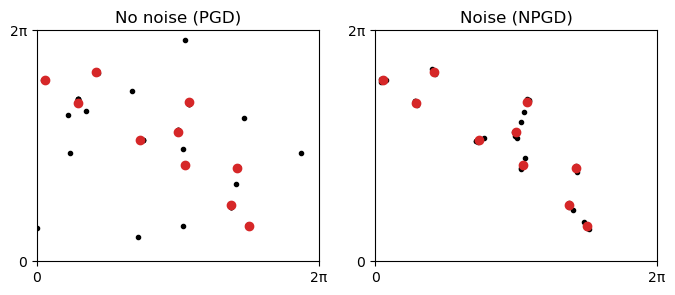

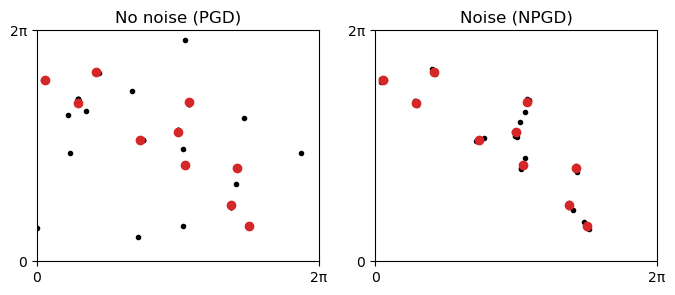

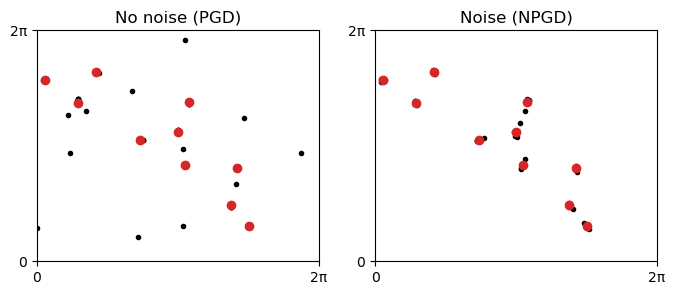

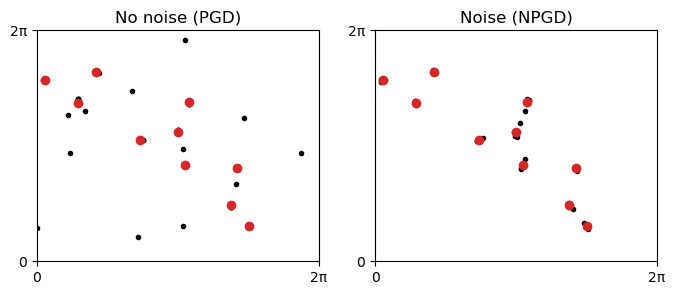

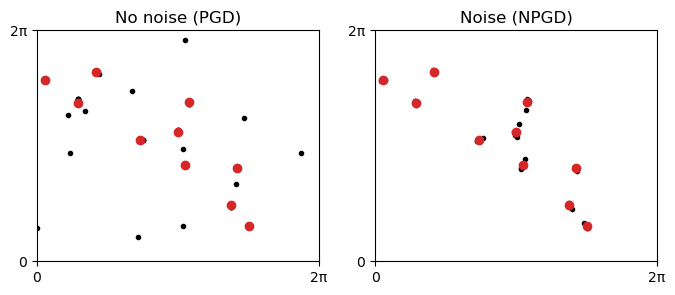

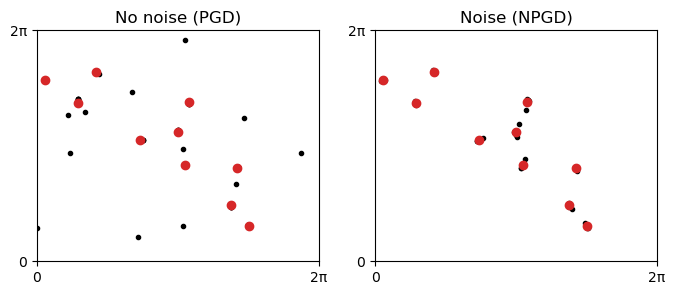

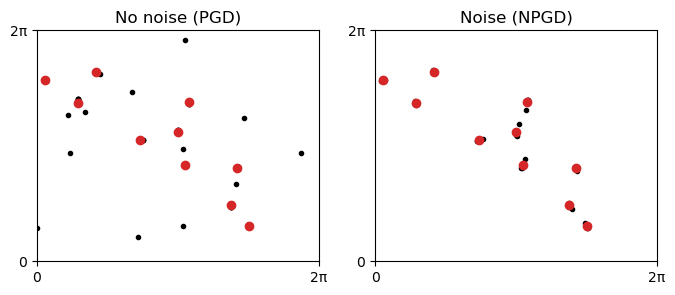

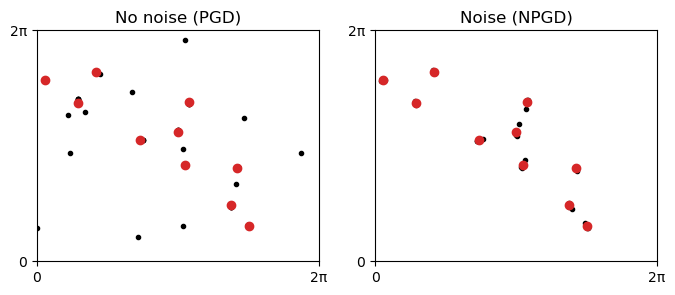

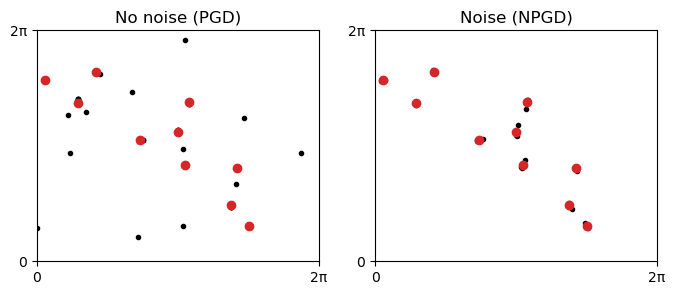

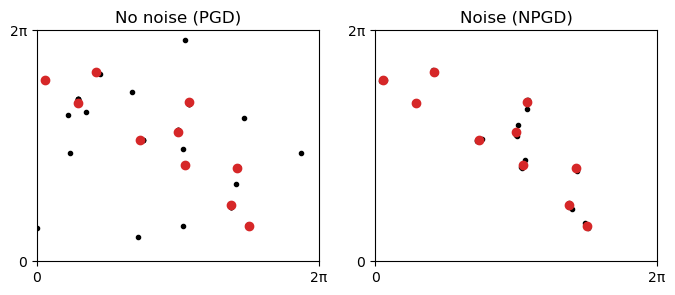

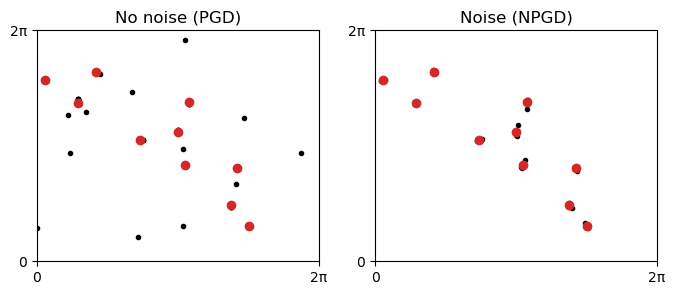

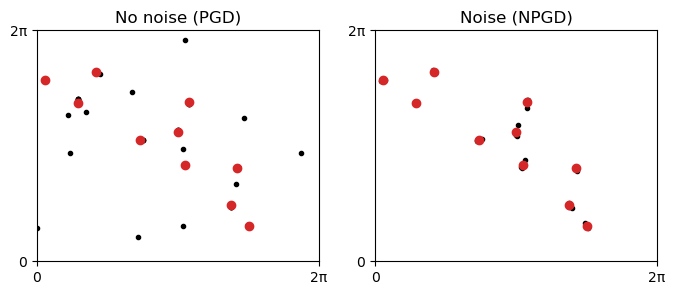

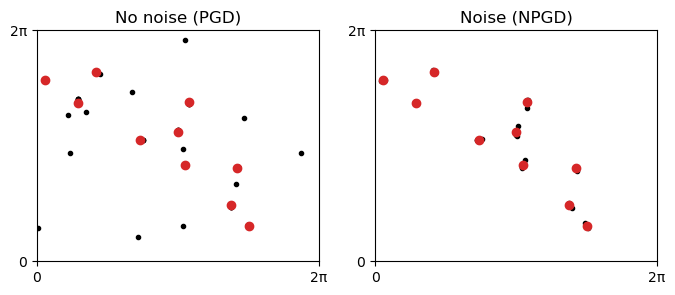

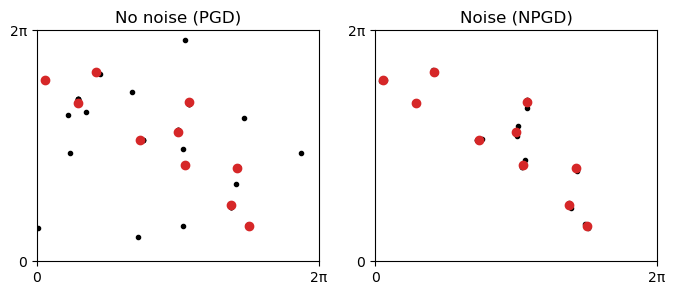

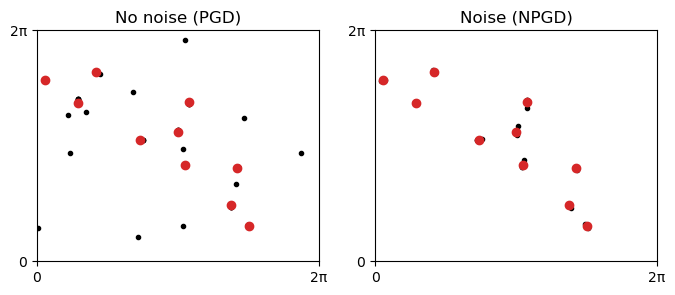

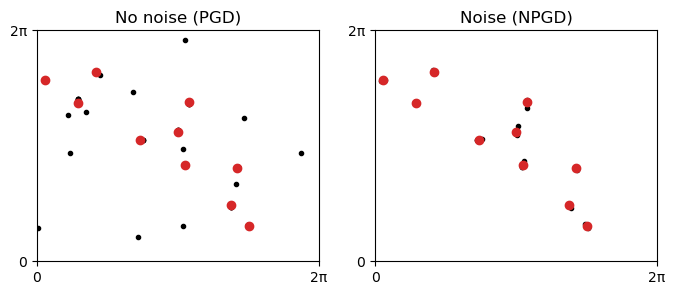

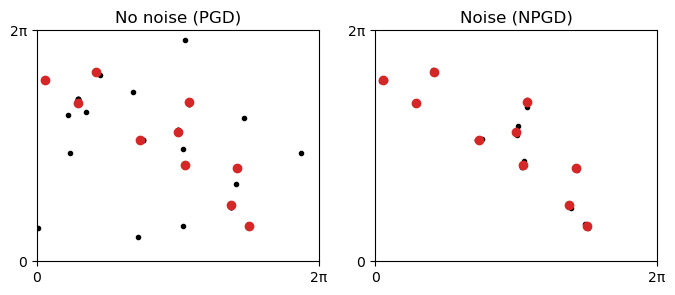

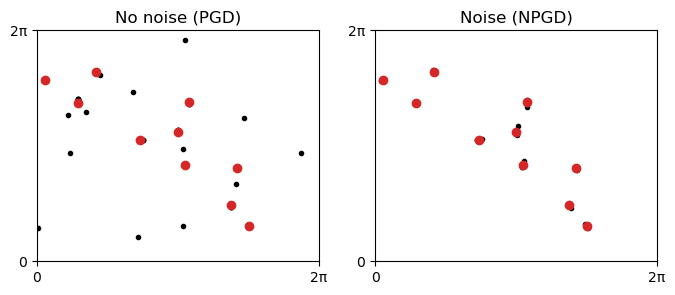

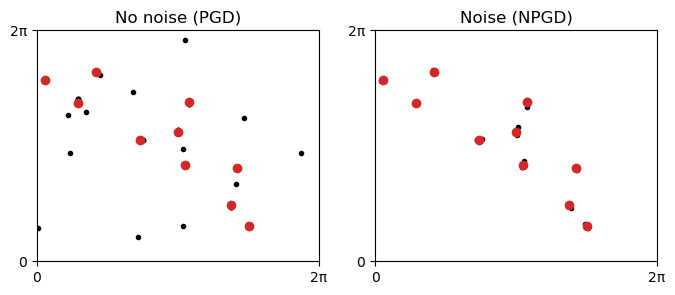

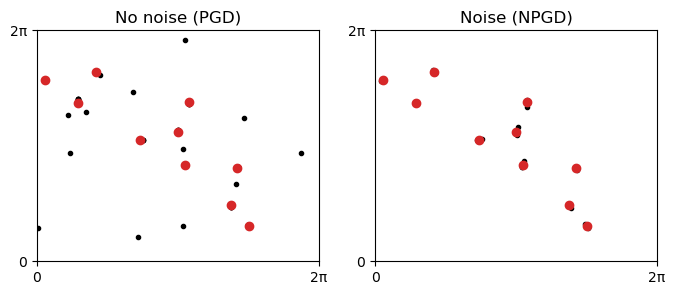

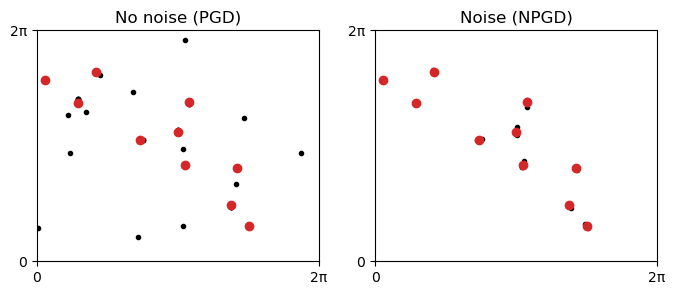

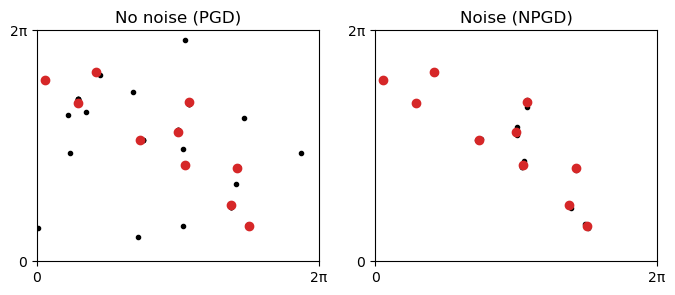

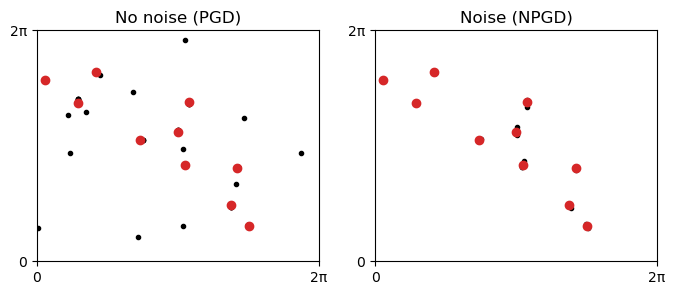

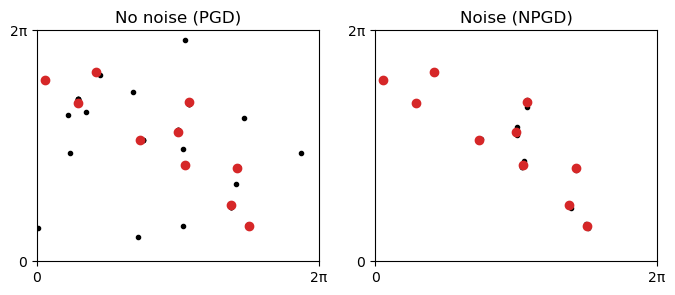

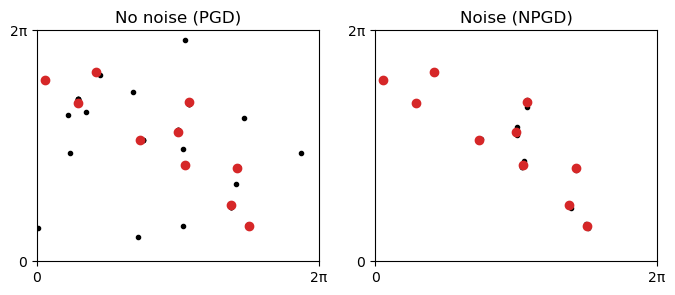

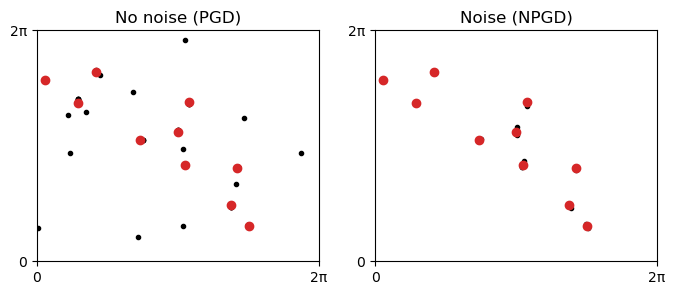

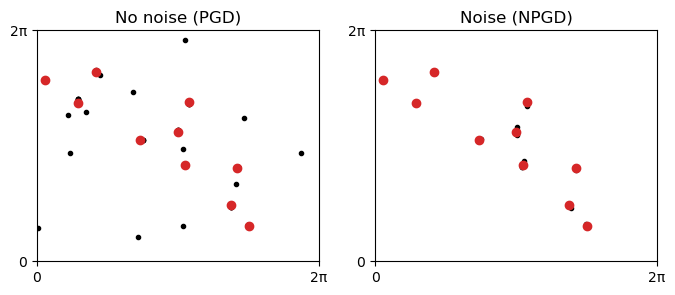

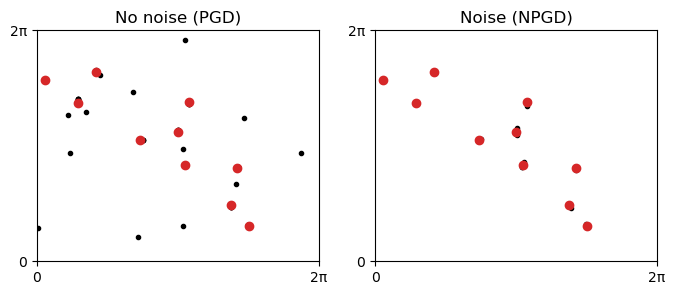

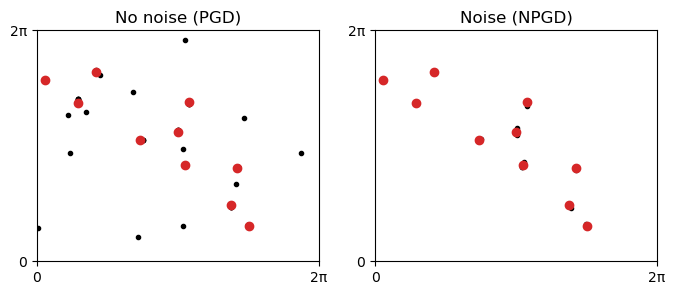

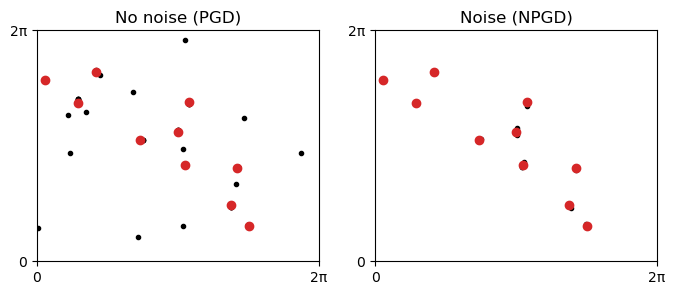

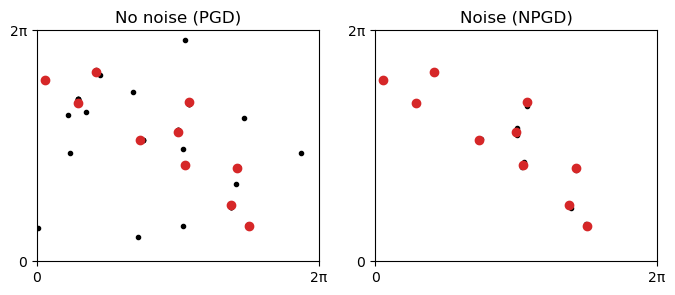

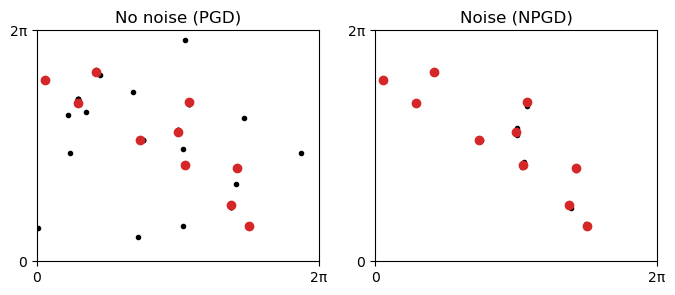

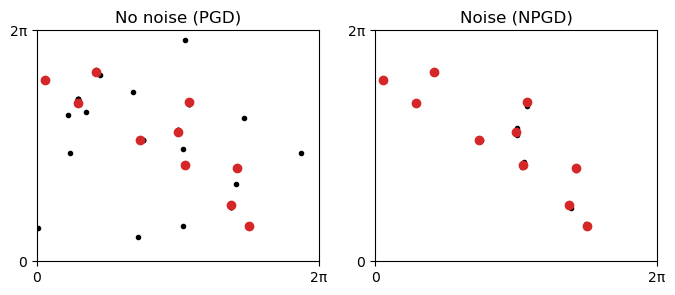

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [39]:
for t=1:10:niter#200#:1:niter
    figure(figsize=[8,3])
    subplot(121)
    axis([0,2π,0,2π])
plot(mod.(X1[1,:,t],2π),mod.(X1[2,:,t],2π),"ko",ms=3)
plot(X_target[1,:], X_target[2,:],"oC3")
xticks([0,2π],["0","2π"])
yticks([0,2π],["0","2π"]);
    title("No noise (PGD)")

    subplot(122)
    axis([0,2π,0,2π])
plot(mod.(X2[1,:,t],2π),mod.(X2[2,:,t],2π),"ko",ms=3)
plot(X_target[1,:], X_target[2,:],"oC3")
xticks([0,2π],["0","2π"])
yticks([0,2π],["0","2π"]);
    title("Noise (NPGD)")
    
    savefig("plot-an-$(t).png")
end

# plot for paper (iteration $t=1500$)

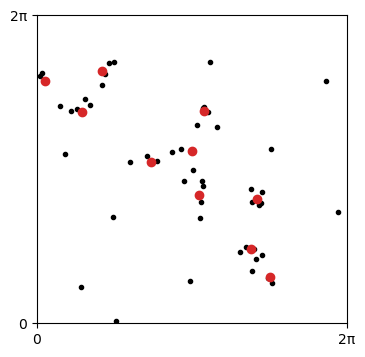

In [21]:
figure(figsize=[4,4])
axis([0,2π,0,2π])
plot(mod.(X2[1,:,1500],2π),mod.(X2[2,:,1500],2π),"ko",ms=3)
plot(X_target[1,:], X_target[2,:],"oC3")
xticks([0,2π],["0","2π"])
yticks([0,2π],["0","2π"]);
    #savefig("config.png",bbox_inches="tight")